<h1 style="text-align: center;">Lorenz 方程</h1>

<p style="text-align: center;">22920242203150 2025-10-14</p>

课程代码均在如下 GitHub 仓库开源：<https://github.com/GHe0000/scientific-programming-intro>

> 注：由于计算和图片较多，同时还有动画，从头运行大概需要 4 分钟.

## 目录

  - [作业要求](#作业要求)
  - [不动点分析](#不动点分析)
  - [轨道演化图](#轨道演化图)
    - [不动点附近为初值](#不动点附近为初值)
    - [轨迹图随 $b$ 的变化](#轨迹图随-b-的变化)
  - [庞加莱截面](#庞加莱截面)
  - [最大李雅普诺夫指数](#最大李雅普诺夫指数)
  - [李雅普诺夫指数](#李雅普诺夫指数)
  - [结论](#结论)
  - [参考资料](#参考资料)
  - [致谢](#致谢)
  - [附一：问题](#附一问题)
  - [附二：学习心得](#附二学习心得)


## 作业要求

Rossler 方程定义如下：

$$
\begin{aligned}
\begin{cases}
\dot{x} = -y-z \\
\dot{y} = x+a y \\
\dot{z} = b+z(x-c)
\end{cases}
\end{aligned}
$$

其中 $a,b,c$ 为正实数.

固定参数 $a=0.2,c=5.7$ 在 $b\in[0.2,2]$ 的范围内探索系统的演化行为，具体要求如下：

- 推导系统的不动点，并在给的参数区间确定其稳定性. （通过数值求解雅克比矩阵）
- 相应地，通过轨道演化图，相图研究若干典型参数的动力学，描述观察到的现象，解释其与不动点稳定性的关系（可选：Lorenz Map 和庞加莱截面方法）
- 相应地，计算若干典型参数下的最大李雅普诺夫指数

要求：排版简介规范，结构分明，要有必要的文字描述和解题思路，推导过程，编程逻辑，现象分析和总结

## 不动点分析

### 解析计算不动点

这里我们先导入需要的库，并针对 Jupyter Notebook 进行一些设置.

In [1]:
import numpy as np # 数值计算库
import numba as nb # 引入 jit 来加速函数（如果需要）
import sympy as sym # 符号计算库
import matplotlib as mpl
import matplotlib.pyplot as plt # 图像绘制
from matplotlib.backends.backend_agg import FigureCanvasAgg # 设置图像后端用
import ipywidgets as ipw # 交互控件
from IPython.display import display, Math, Latex # 打印数学公式


import matplotlib.animation as animation # 创建动画
from IPython.display import HTML # 动画嵌入
import scipy

# 设置随机数种子确保结果的可复现性
np.random.seed(3407)

# 使用 mathjax 来在 jupyter notebook 显示数学公式
sym.init_printing(use_latex='mathjax')

# 设置 matplotlib 绘制的图像嵌入到 jupyter notebook 的方式
%matplotlib widget

# 一个工具函数，可以让静态图片不经过 widget 直接嵌入 Jupyter notebook
# 这样图片可以直接存到 nb 文件里，而不是需要运行才能显示（类似 inline）
def display_inline(fig):
    fig.set_canvas(FigureCanvasAgg(fig))
    display(fig)
    plt.close(fig) # 释放 fig，减小资源消耗

# 一个工具函数，用于在 Jupyter 中快速实现公式和字符串混合输出
def display_math(*args):
    parts = []
    for a in args:
        if isinstance(a, str):
            parts.append(a)
        else:
            parts.append(sym.latex(a))
    display(Math("".join(parts)))

# 设置 matplotlib 使用的字体，避免出现中文问题
plt.rcParams['font.family'] = ['SimSun', 'Times New Roman']
plt.rcParams['mathtext.fontset'] = 'cm'
# 设置默认坐标轴字体大小
plt.rcParams['axes.labelsize'] = 14

我们要计算不动点，就是要求满足 $\dot{x}=\dot{y}=\dot{z}=0$ 的方程，我们通过 `sympy` 求解如下：

In [2]:
sym.var("x,y,z,a,b,c")
F = sym.Matrix([-y-z,
               x+a*y,
               b+z*(x-c)])
sol=sym.solve(F,(x,y,z))
sol

⎡⎛       _____________          _____________           _____________⎞  ⎛      ↪
⎢⎜      ╱           2          ╱           2           ╱           2 ⎟  ⎜      ↪
⎢⎜c   ╲╱  -4⋅a⋅b + c    -c + ╲╱  -4⋅a⋅b + c     c    ╲╱  -4⋅a⋅b + c  ⎟  ⎜c   ╲ ↪
⎢⎜─ - ────────────────, ─────────────────────, ─── - ────────────────⎟, ⎜─ + ─ ↪
⎣⎝2          2                   2⋅a           2⋅a         2⋅a       ⎠  ⎝2     ↪

↪   _____________          _____________           _____________⎞⎤
↪  ╱           2          ╱           2           ╱           2 ⎟⎥
↪ ╱  -4⋅a⋅b + c    -c - ╲╱  -4⋅a⋅b + c     c    ╲╱  -4⋅a⋅b + c  ⎟⎥
↪ ───────────────, ─────────────────────, ─── + ────────────────⎟⎥
↪       2                   2⋅a           2⋅a         2⋅a       ⎠⎦

也就是系统有两个不动点 $C_+,C_-$，不动点的坐标满足：

$$
C_{\pm} = \left( \frac{c}{2} \pm \frac{\sqrt{- 4 a b + c^{2}}}{2}, \  \frac{- c \mp \sqrt{- 4 a b + c^{2}}}{2 a}, \  \frac{c}{2 a} \pm \frac{\sqrt{- 4 a b + c^{2}}}{2 a}\right)
$$

不动点存在的条件为判别式 $\Delta=c^2-4ab>0$，

对于 $a=0.2,c=5.7,b\in[0.2,2]$，容易计算验证 $\Delta>0$，两个不动点均存在.

### 数值求解不动点稳定性

下面我们通过数值计算不动点的稳定性. 首先系统的 Jacobian 矩阵为：

In [3]:
X = sym.Matrix([x,y,z])
J=F.jacobian(X)
J

⎡0  -1    -1  ⎤
⎢             ⎥
⎢1  a     0   ⎥
⎢             ⎥
⎣z  0   -c + x⎦

记系统的 Jacobian 矩阵为 $\mathbf{J}$. 给定某个稳定点 $\mathbf{x}^* = (x,y,z)^\mathrm{T}$，其该点的 Jacobian 矩阵为 $\mathbf{J}(\mathbf{x}^*)$，我们总可以对其计算本征值，得到 $\lambda_1, \lambda_2, \lambda_3$. 这里 $\lambda_{1,2,3}$ 可能是复数的形式，我们只关心其实部 $\mathrm{Re}({\lambda_{1,2,3}})$

固定参数 $a=0.2,c=5.7$ 在 $b\in[0.2,2]$ 的范围内采样，我们得到 $\lambda_{1,2,3}$ 随 $b$ 的变化曲线：

In [4]:
@nb.njit()
def f(X,a,b,c):
    return np.array([-X[1]-X[2],
                     X[0]+a*X[1],
                     b+X[2]*(X[0]-c)])

@nb.njit()
def jac(X,a,b,c):
    return np.array([[0., -1.,      -1.],
                     [1.,   a,       0.],
                     [X[2], 0., -c+X[0]]])

@nb.njit()
def stable_pt(a,b,c):
    delta = c**2 -4*a*b
    Cp = np.array([(c+np.sqrt(delta))/2.0,
                   (-c-np.sqrt(delta))/(2.0*a),
                   (c+np.sqrt(delta))/(2.0*a)])
    Cm = np.array([(c-np.sqrt(delta))/2.0,
                   (-c+np.sqrt(delta))/(2.0*a),
                   (c-np.sqrt(delta))/(2.0*a)])
    return Cp, Cm

#@nb.njit(parallel=True, cache=True) 
def calc_lambda_real_vs_b(b_arr, a, c):
    def single(b,a,c): # 单线程的 Task
        Cp, Cm = stable_pt(a,b,c)
        Jp = jac(Cp,a,b,c)
        Jm = jac(Cm,a,b,c)
        egv_p = np.linalg.eigvals(Jp) # eigvals 不支持 JIT，不能多线程计算，悲
        egv_m = np.linalg.eigvals(Jm)
        lp = np.sort(egv_p.real)
        lm = np.sort(egv_m.real)
        len_lp, len_lm = len(lp), len(lm)
        ans = np.zeros(len_lp+len_lm, dtype=np.float64)
        ans[:len_lp] = lp
        ans[len_lp:] = lm
        return ans
    n_b = len(b_arr)
    ans = np.zeros((n_b, 6), dtype=np.float64)
    for i in nb.prange(n_b): # 多线程并行计算
        ans[i] = single(b_arr[i], a, c)
    return ans

a = 0.2
c = 5.7
b_arr = np.linspace(0.2,2,1000)
lambda_real = calc_lambda_real_vs_b(b_arr, a, c)

对于 $C_+$，其 $\lambda_{1,2,3}$ 实部随 $b$ 的变化曲线如下：

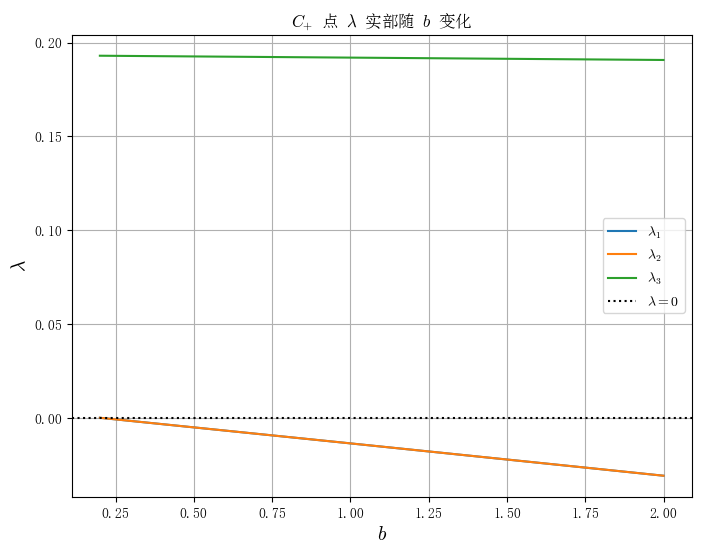

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(3):
    ax.plot(b_arr, lambda_real[:,i], label=f"$\\lambda_{i+1}$")
ax.axhline(0, color='k', linestyle=':', label=r"$\lambda=0$")
ax.set_xlabel("$b$")
ax.set_ylabel("$\\lambda$")
ax.set_title(r"$C_{+}$ 点 $\lambda$ 实部随 $b$ 变化")
ax.grid()
ax.legend()
display_inline(fig)

图像中应该出现三条线，但只有两条线，说明有两条线出现了重合. 这是合理的，因为对于 $\mathbf{J}$ 的特征方程一定是一个关于 $\lambda$ 的一元三次实多项式方程. 而根据代数基本定理中的“虚根成对”，如果方程有复数根 $\lambda$，则复数根的共轭 $\overline{\lambda}$ 也是原方程的根. 而这两个根的实部相等：$\mathrm{Re}(\lambda) = \mathrm{Re}(\overline{\lambda})$

至于是那两条线重合，是有两个实部大于 $0$ 的 $\lambda$ 还是只有一个，在后面绘制虚部时会讨论.

对于另一个点，我们同样可以绘制其 $\lambda_{1,2,3}$ 实部随 $b$ 的变化曲线如下：

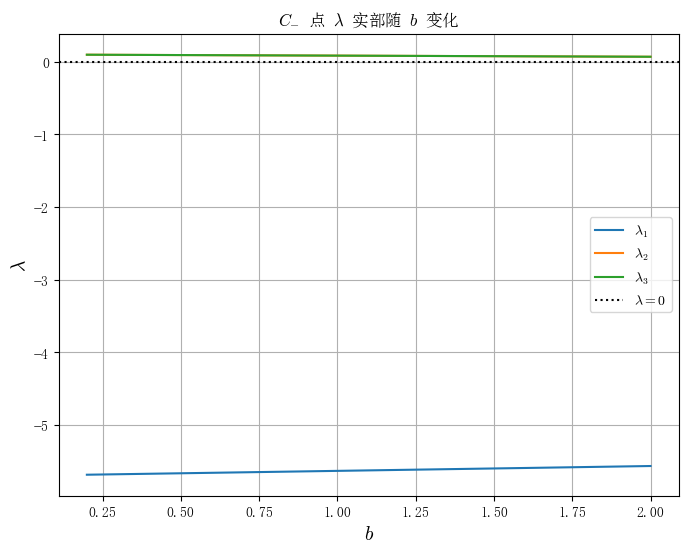

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(3):
    ax.plot(b_arr, lambda_real[:,i+3], label=f"$\\lambda_{i+1}$")
ax.axhline(0, color='k', linestyle=':', label=r"$\lambda=0$")
ax.set_xlabel("$b$")
ax.set_ylabel("$\\lambda$")
ax.set_title(r"$C_{-}$ 点 $\lambda$ 实部随 $b$ 变化")
ax.grid()
ax.legend()
display_inline(fig)

由于前文的同样的原因，这里只出现了两条线.

这里我们更关系 $\max\{\mathrm{Re}(\lambda_{1,2,3})\}$，我们绘制 $C_\pm$ 的 Jacobian 矩阵本征值实部的最大值随 $b$ 的变化：

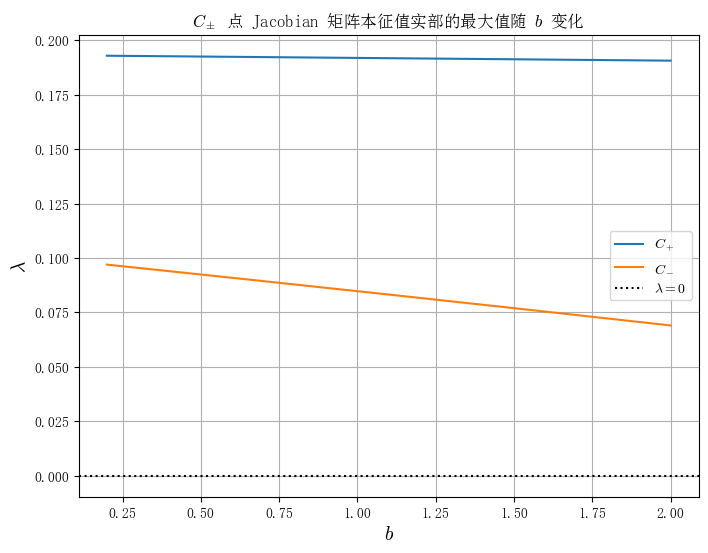

In [7]:
lambda_p_max = np.max(lambda_real[:,:3], axis=1)
lambda_m_max = np.max(lambda_real[:,3:], axis=1)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(b_arr, lambda_p_max, label="$C_+$")
ax.plot(b_arr, lambda_m_max, label="$C_-$")
ax.axhline(0, color='k', linestyle=':', label=r"$\lambda=0$")
ax.set_xlabel("$b$")
ax.set_ylabel("$\\lambda$")
ax.set_title(r"$C_\pm$ 点 Jacobian 矩阵本征值实部的最大值随 $b$ 变化")
ax.grid()
ax.legend()
display_inline(fig)

可以发现，在整个 $b$ 的范围内，两个不动点都是不稳定的（Jacobian 矩阵特征值的实部最大值均大于 $0$）.

对于虚部，我们同样可以进行计算并绘图：

In [8]:
def calc_lambda_imag_vs_b(b_arr, a, c):
    def single(b,a,c): # 单线程的 Task
        Cp, Cm = stable_pt(a,b,c)
        Jp = jac(Cp,a,b,c)
        Jm = jac(Cm,a,b,c)
        egv_p = np.linalg.eigvals(Jp) # eigvals 不支持 JIT，不能多线程计算，悲
        egv_m = np.linalg.eigvals(Jm)
        lp = np.sort(egv_p.imag)
        lm = np.sort(egv_m.imag)
        len_lp, len_lm = len(lp), len(lm)
        ans = np.zeros(len_lp+len_lm, dtype=np.float64)
        ans[:len_lp] = lp
        ans[len_lp:] = lm
        return ans
    n_b = len(b_arr)
    ans = np.zeros((n_b, 6), dtype=np.float64)
    for i in nb.prange(n_b): # 多线程并行计算
        ans[i] = single(b_arr[i], a, c)
    return ans

a = 0.2
c = 5.7
b_arr = np.linspace(0.2,2,1000)
lambda_imag = calc_lambda_imag_vs_b(b_arr, a, c)

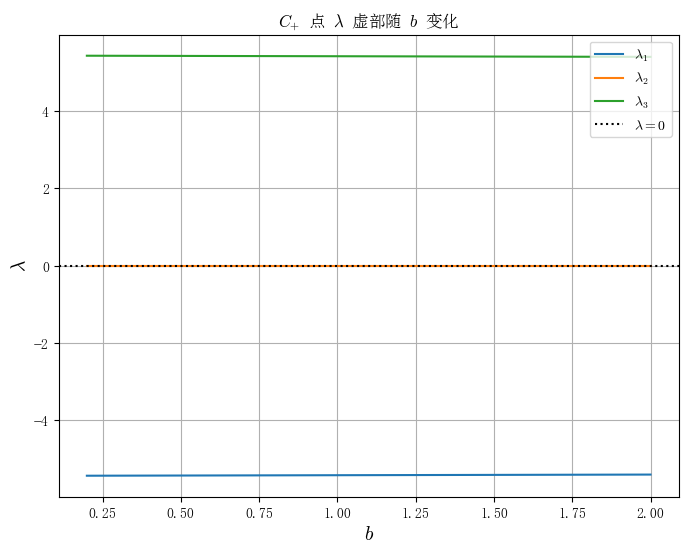

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(3):
    ax.plot(b_arr, lambda_imag[:,i], label=f"$\\lambda_{i+1}$")
ax.axhline(0, color='k', linestyle=':', label=r"$\lambda=0$")
ax.set_xlabel("$b$")
ax.set_ylabel("$\\lambda$")
ax.set_title(r"$C_{+}$ 点 $\lambda$ 虚部随 $b$ 变化")
ax.grid()
ax.legend()
display_inline(fig)

可以发现，对于 $C_+$ 点，其中一个 $\lambda$ 的虚部为 $0$，另外两个的虚部互为相反数（两个 $\lambda$ 共轭），结合前面的实部的图，我们知道，对于 $C_+$ 点，其两个 $\lambda$ 实部大于 $0$ 一个 $\lambda$ 实部小于 $0$. 其附近轨迹应该是旋转地离开. 同理，对于 $C_-$ 点：

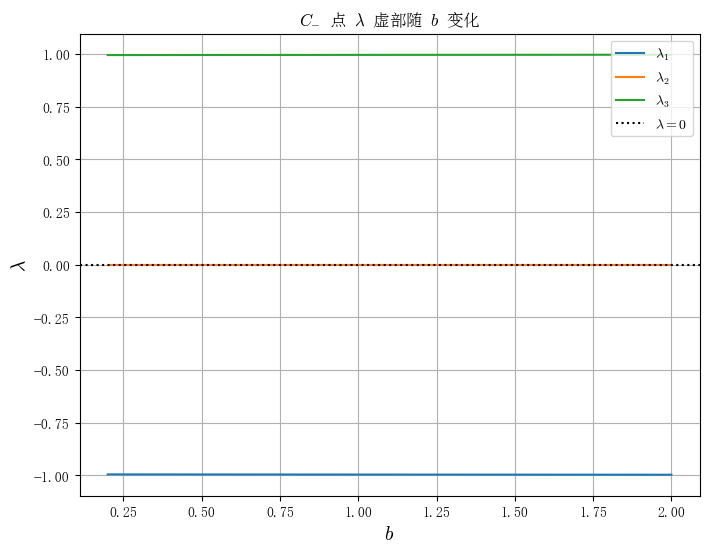

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(3):
    ax.plot(b_arr, lambda_imag[:,i+3], label=f"$\\lambda_{i+1}$")
ax.axhline(0, color='k', linestyle=':', label=r"$\lambda=0$")
ax.set_xlabel("$b$")
ax.set_ylabel("$\\lambda$")
ax.set_title(r"$C_{-}$ 点 $\lambda$ 虚部随 $b$ 变化")
ax.grid()
ax.legend()
display_inline(fig)

结合前面的实部的图，我们知道，对于 $C_-$ 点，其两个 $\lambda$ 实部小于 $0$ 一个 $\lambda$ 实部大于 $0$. 其附近轨迹应该是旋转地离开.

## 轨道演化图

### 不动点附近为初值

这里我们使用 `scipy` 的 ODE 求解器来求解轨道演化图. 由于前面的分析中我们知道，在给定 $b$ 的范围中，其两个不动点的整体的性质没有太大变化，因此. 这里我们取 $r=0.2$，并且取初始点 $X_0$ 接近 $C_+$ 点，取时间步长为 $0.01$, 绘制 $500$ 个单位的时间（下同，且默认绘制 $500$ 个单位时间）

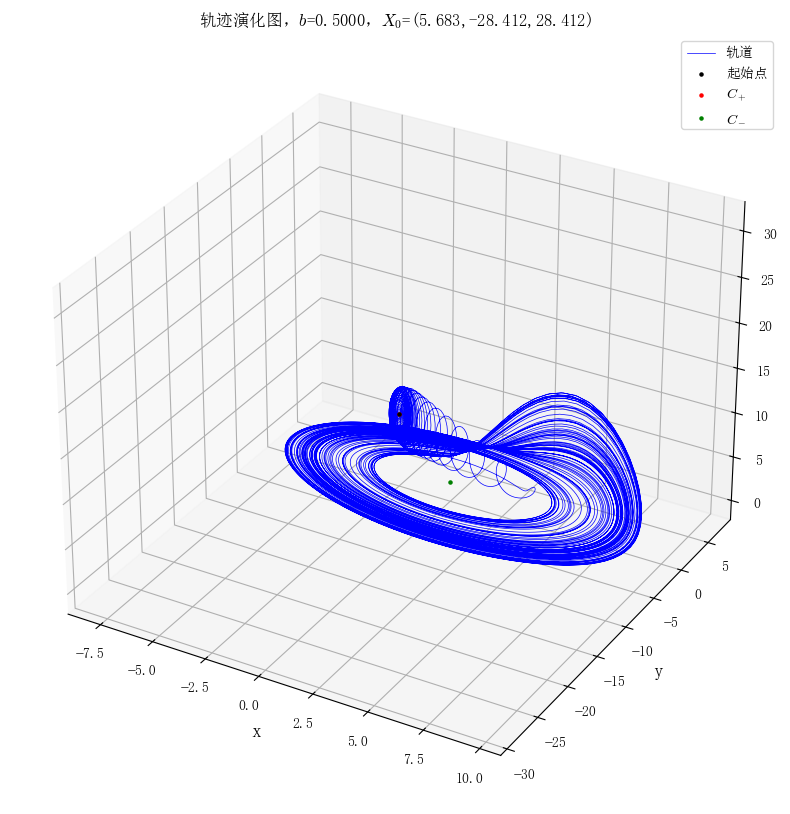

In [11]:
b = 0.5
a = 0.2
c = 5.7

t_max = 500
t_span = (0, t_max)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

Cp, Cm = stable_pt(a,b,c)
X0 = Cp + np.array([1e-3,0.,0.])

def solve_eq(t, u, a, b, c):
    x, y, z = u
    return [-y-z, x+a*y, b+z*(x-c)]

solution = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(a, b, c),
    dense_output=True,
    t_eval=t_eval
)

x, y, z = solution.y

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
ax.scatter(*X0, c='k', s=5, label="起始点")
Cp, Cm = stable_pt(a,b,c)
ax.scatter(*Cp, c='r', s=5, label="$C_+$")
ax.scatter(*Cm, c='g', s=5, label="$C_-$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")
display_inline(fig)

可以发现，确实在 $C_+$ 附近，轨迹是旋转地离开，符合我们前面的分析. 同理，对于 $C_-$ 点：

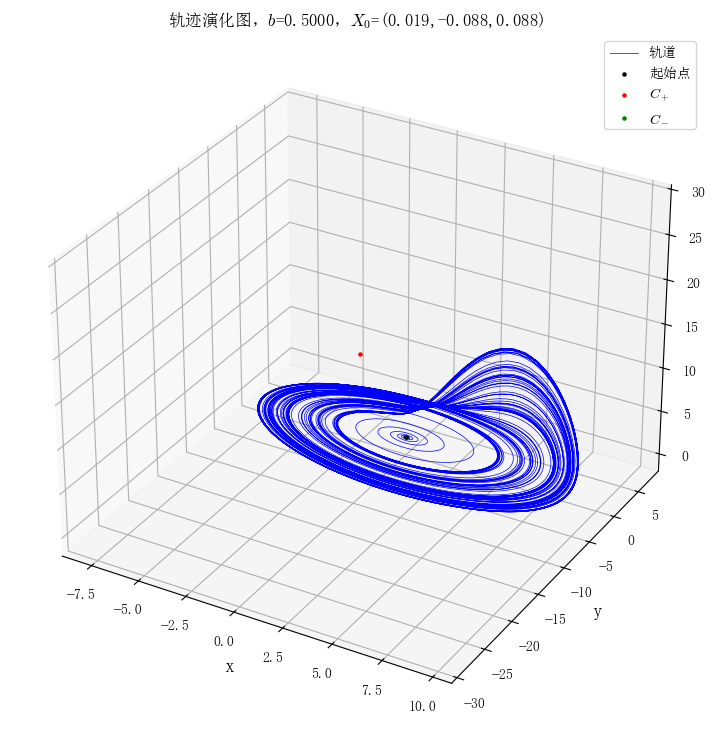

In [12]:
b = 0.5
a = 0.2
c = 5.7

t_max = 500
t_span = (0, t_max)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

Cp, Cm = stable_pt(a,b,c)
X0 = Cm + np.array([1e-3,0.,0.])

def solve_eq(t, u, a, b, c):
    x, y, z = u
    return [-y-z, x+a*y, b+z*(x-c)]

solution = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(a, b, c),
    dense_output=True,
    t_eval=t_eval
)

x, y, z = solution.y

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
ax.scatter(*X0, c='k', s=5, label="起始点")
Cp, Cm = stable_pt(a,b,c)
ax.scatter(*Cp, c='r', s=5, label="$C_+$")
ax.scatter(*Cm, c='g', s=5, label="$C_-$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")
display_inline(fig)

其一开始确实也是旋转地离开.

综上我们验证了两个不动点都是不稳定不动点，且附近轨迹是旋转地远离不动点，这和我们前面的分析结论相同.

### 轨迹图随 $b$ 的变化

#### 整个 $b$ 的取值范围

下面我们研究轨迹图随 $b$ 的变化过程，固定 $\mathbf{x}_0=(2.5,0,0)$，改变 $b$，观察轨迹如何演化.

> 注：动态绘图由于使用了 `widget` 来嵌入 Jupyter Notebook 而不是像其他静态图作为图片嵌入，因此需要运行 Cell 才能显示）

interactive(children=(FloatSlider(value=0.2, description='b', max=2.0, min=0.2, step=0.01), Output()), _dom_cl…

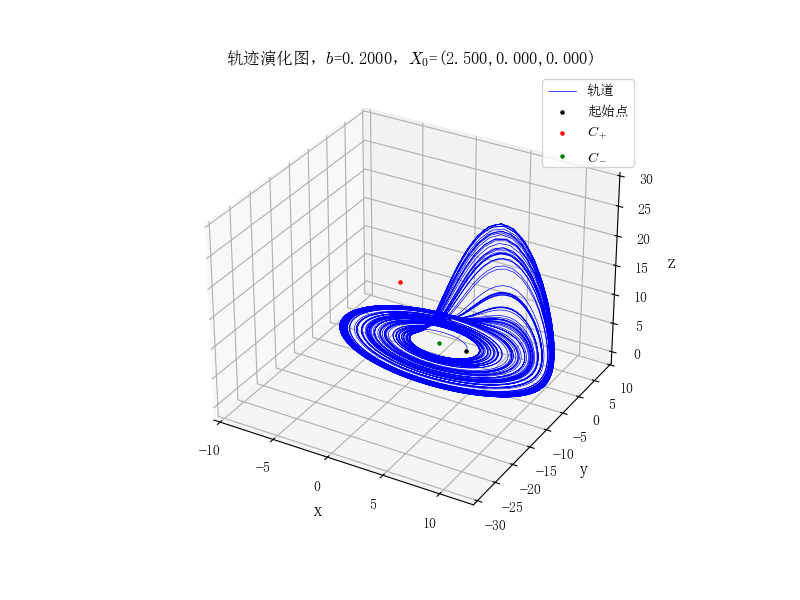

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

@ipw.interact(
    b=(0.2, 2.0, 0.01),
)
def update(b=0.2):
    ax.clear()
    a = 0.2
    c = 5.7
    t_max = 500
    t_span = (0, t_max)
    t_eval = np.linspace(t_span[0], t_span[1], 10000)
    Cp, Cm = stable_pt(a,b,c)
    X0 = np.array([2.5,0.,0.])
    def solve_eq(t, u, a, b, c):
        x, y, z = u
        return [-y-z, x+a*y, b+z*(x-c)]
    solution = scipy.integrate.solve_ivp(
        fun=solve_eq,
        t_span=t_span,
        y0=X0,
        args=(a, b, c),
        dense_output=True,
        t_eval=t_eval
    )
    x, y, z = solution.y
    ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
    ax.scatter(*X0, c='k', s=5, label="起始点")
    ax.scatter(*Cp, c='r', s=5, label="$C_+$")
    ax.scatter(*Cm, c='g', s=5, label="$C_-$")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend()
    ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")

我们将上述过程转变为动画（$b$ 均匀增大）

> 下面 Cell 需要运行较长时间

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

b_arr = np.arange(0.2, 2.0, 0.05)
def update(frame):
    ax.clear()
    b = b_arr[frame]
    a = 0.2
    c = 5.7
    t_max = 500
    t_span = (0, t_max)
    t_eval = np.linspace(t_span[0], t_span[1], 10000)
    Cp, Cm = stable_pt(a,b,c)
    X0 = np.array([2.5,0.,0.])
    def solve_eq(t, u, a, b, c):
        x, y, z = u
        return [-y-z, x+a*y, b+z*(x-c)]
    solution = scipy.integrate.solve_ivp(
        fun=solve_eq,
        t_span=t_span,
        y0=X0,
        args=(a, b, c),
        dense_output=True,
        t_eval=t_eval
    )
    x, y, z = solution.y
    ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
    ax.scatter(*X0, c='k', s=5, label="起始点")
    ax.scatter(*Cp, c='r', s=5, label="$C_+$")
    ax.scatter(*Cm, c='g', s=5, label="$C_-$")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend()
    ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")

ani = animation.FuncAnimation(fig, update, frames=len(b_arr), interval=200)
html_video = HTML(ani.to_html5_video())
plt.close(fig)
display(html_video)

从上面的交互和动画可以看出，随着 $b$ 的增大，其在 $b\approx 0.3$ 附近短暂出现周期轨道，随后继续混沌，在 $b\approx 0.85$ 时周期轨道再一次开始出现，直到 $b\approx 1.42$ 开始轨道貌似出现混沌，并在后面轨迹逐渐“收缩”，直至 $b=2$ 又近似出现周期轨道.

我们挑选上面得到的几个 $b$ 进行绘制：

首先我们先选取一个一般的混沌的情况：

#### $b=0.5$（混沌代表）

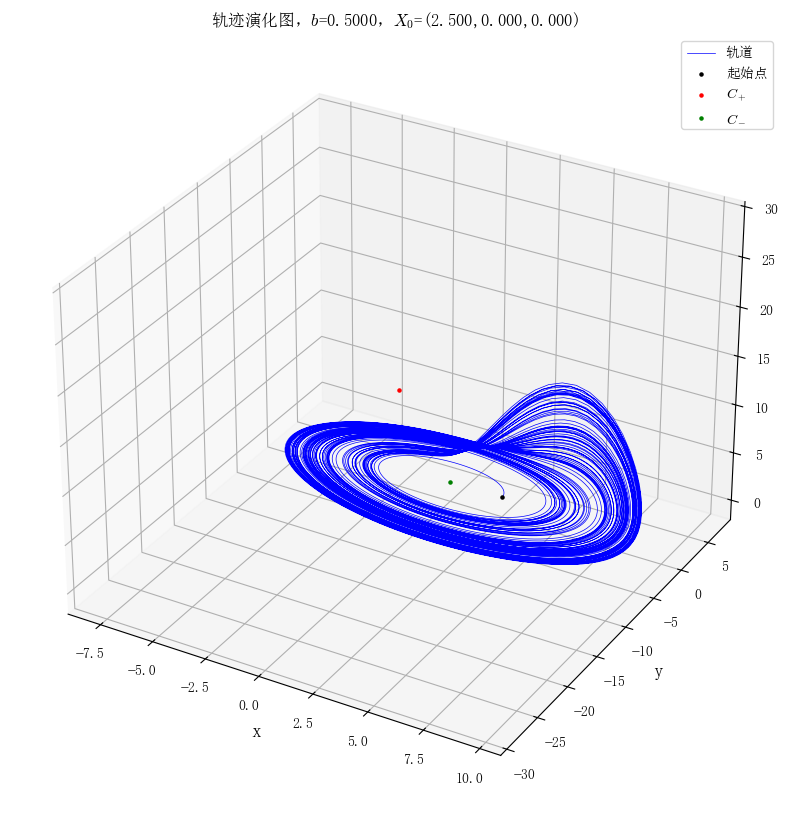

In [15]:
b = 0.5
a = 0.2
c = 5.7

t_max = 500
t_span = (0, t_max)
t_eval = np.linspace(t_span[0], t_span[1], 10000)
Cp, Cm = stable_pt(a,b,c)
X0 = np.array([2.5,0.,0.])
def solve_eq(t, u, a, b, c):
    x, y, z = u
    return [-y-z, x+a*y, b+z*(x-c)]

solution = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(a, b, c),
    dense_output=True,
    t_eval=t_eval
)
x, y, z = solution.y
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
ax.scatter(*X0, c='k', s=5, label="起始点")
ax.scatter(*Cp, c='r', s=5, label="$C_+$")
ax.scatter(*Cm, c='g', s=5, label="$C_-$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")
display_inline(fig)

可以看到轨迹“平铺”在某一块空间，没有明显的周期轨道.

同时我们给出一般的有周期轨道的情况：

#### $b=1.3$（周期轨道代表）

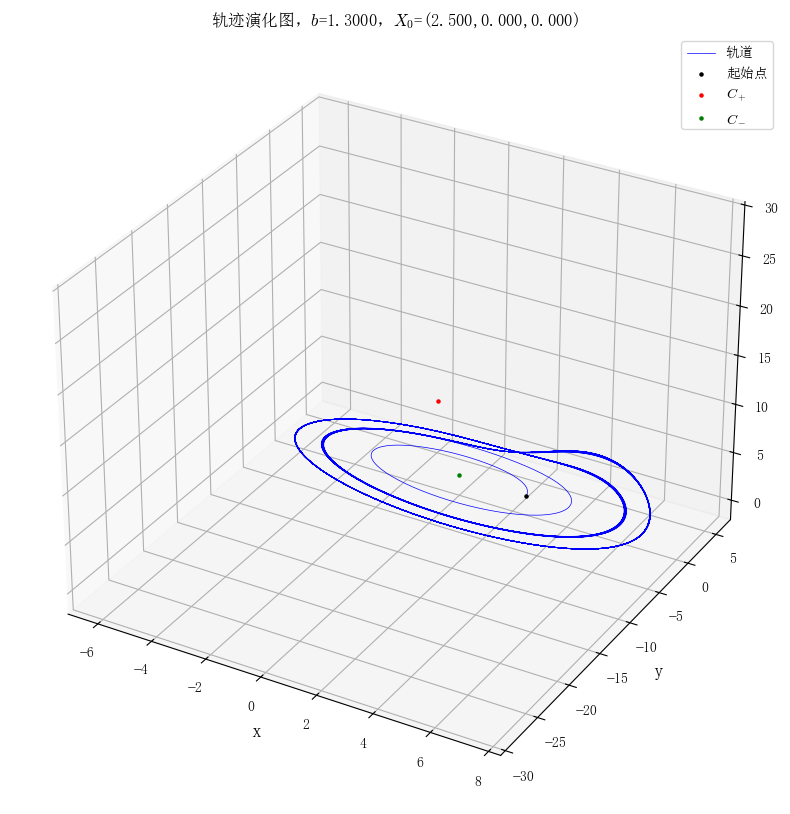

In [16]:
b = 1.3
a = 0.2
c = 5.7

t_max = 500
t_span = (0, t_max)
t_eval = np.linspace(t_span[0], t_span[1], 10000)
Cp, Cm = stable_pt(a,b,c)
X0 = np.array([2.5,0.,0.])
def solve_eq(t, u, a, b, c):
    x, y, z = u
    return [-y-z, x+a*y, b+z*(x-c)]

solution = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(a, b, c),
    dense_output=True,
    t_eval=t_eval
)
x, y, z = solution.y
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
ax.scatter(*X0, c='k', s=5, label="起始点")
ax.scatter(*Cp, c='r', s=5, label="$C_+$")
ax.scatter(*Cm, c='g', s=5, label="$C_-$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")
display_inline(fig)

可以看到轨迹最后基本在一条固定的轨道上，轨道大概旋转两圈回到起点，是一个周期二轨道.

下面我们给出前面得到的分界处的 $b$ 所对应的轨迹演化图.

#### $b=0.3$

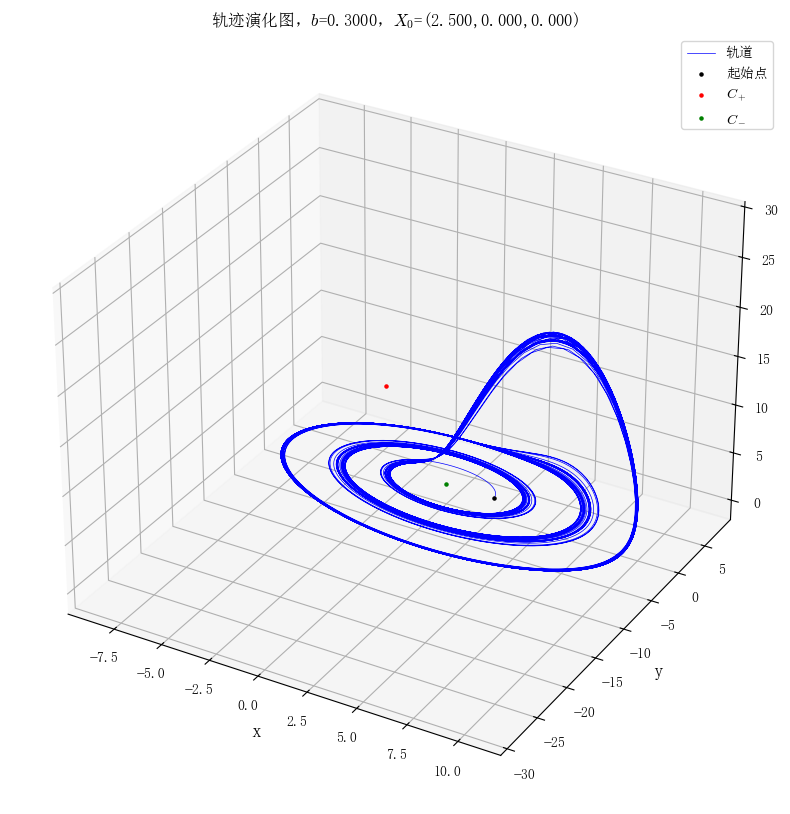

In [17]:
b = 0.3
a = 0.2
c = 5.7

t_max = 500
t_span = (0, t_max)
t_eval = np.linspace(t_span[0], t_span[1], 10000)
Cp, Cm = stable_pt(a,b,c)
X0 = np.array([2.5,0.,0.])
def solve_eq(t, u, a, b, c):
    x, y, z = u
    return [-y-z, x+a*y, b+z*(x-c)]

solution = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(a, b, c),
    dense_output=True,
    t_eval=t_eval
)
x, y, z = solution.y
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
ax.scatter(*X0, c='k', s=5, label="起始点")
ax.scatter(*Cp, c='r', s=5, label="$C_+$")
ax.scatter(*Cm, c='g', s=5, label="$C_-$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")
display_inline(fig)

#### $b=0.85$

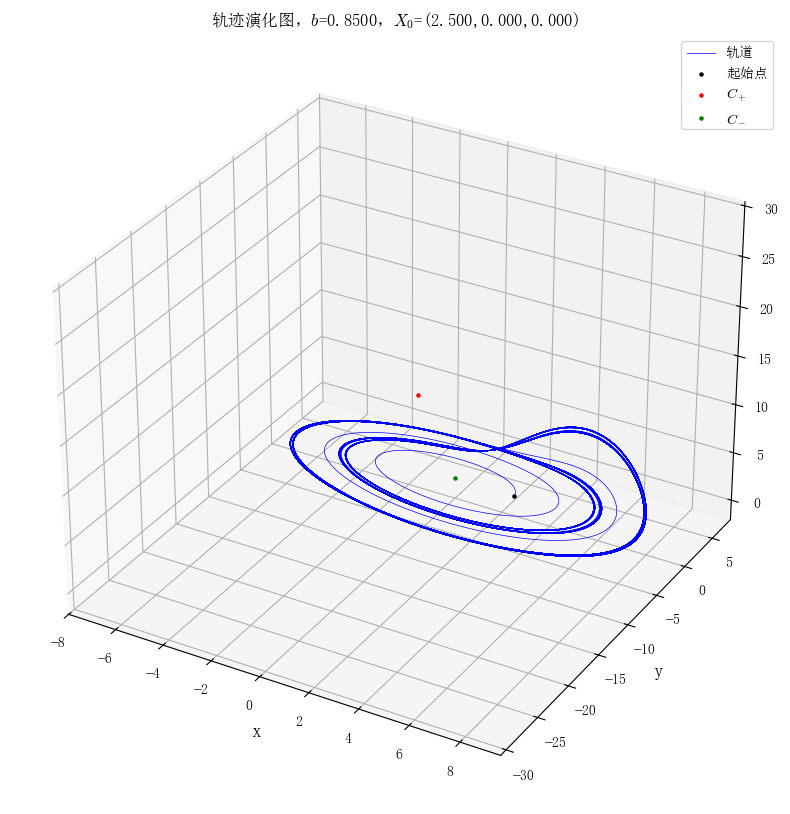

In [18]:
b = 0.85
a = 0.2
c = 5.7

t_max = 500
t_span = (0, t_max)
t_eval = np.linspace(t_span[0], t_span[1], 10000)
Cp, Cm = stable_pt(a,b,c)
X0 = np.array([2.5,0.,0.])
def solve_eq(t, u, a, b, c):
    x, y, z = u
    return [-y-z, x+a*y, b+z*(x-c)]

solution = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(a, b, c),
    dense_output=True,
    t_eval=t_eval
)
x, y, z = solution.y
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
ax.scatter(*X0, c='k', s=5, label="起始点")
ax.scatter(*Cp, c='r', s=5, label="$C_+$")
ax.scatter(*Cm, c='g', s=5, label="$C_-$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")
display_inline(fig)

#### $b=1.42$

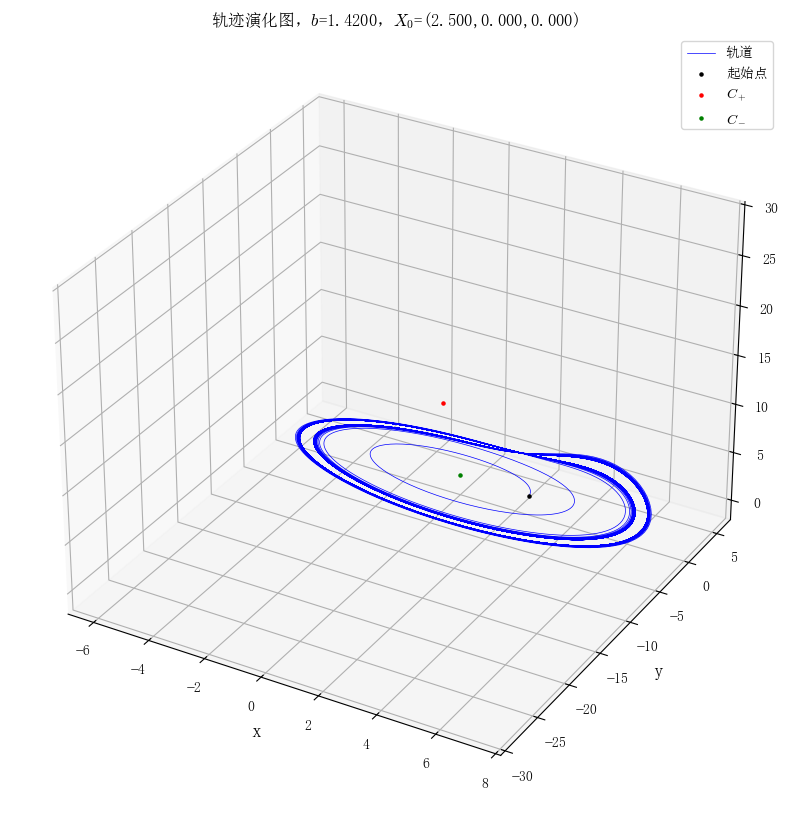

In [19]:
b = 1.42
a = 0.2
c = 5.7

t_max = 500
t_span = (0, t_max)
t_eval = np.linspace(t_span[0], t_span[1], 10000)
Cp, Cm = stable_pt(a,b,c)
X0 = np.array([2.5,0.,0.])
def solve_eq(t, u, a, b, c):
    x, y, z = u
    return [-y-z, x+a*y, b+z*(x-c)]

solution = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(a, b, c),
    dense_output=True,
    t_eval=t_eval
)
x, y, z = solution.y
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
ax.scatter(*X0, c='k', s=5, label="起始点")
ax.scatter(*Cp, c='r', s=5, label="$C_+$")
ax.scatter(*Cm, c='g', s=5, label="$C_-$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")
display_inline(fig)

#### $b=2$

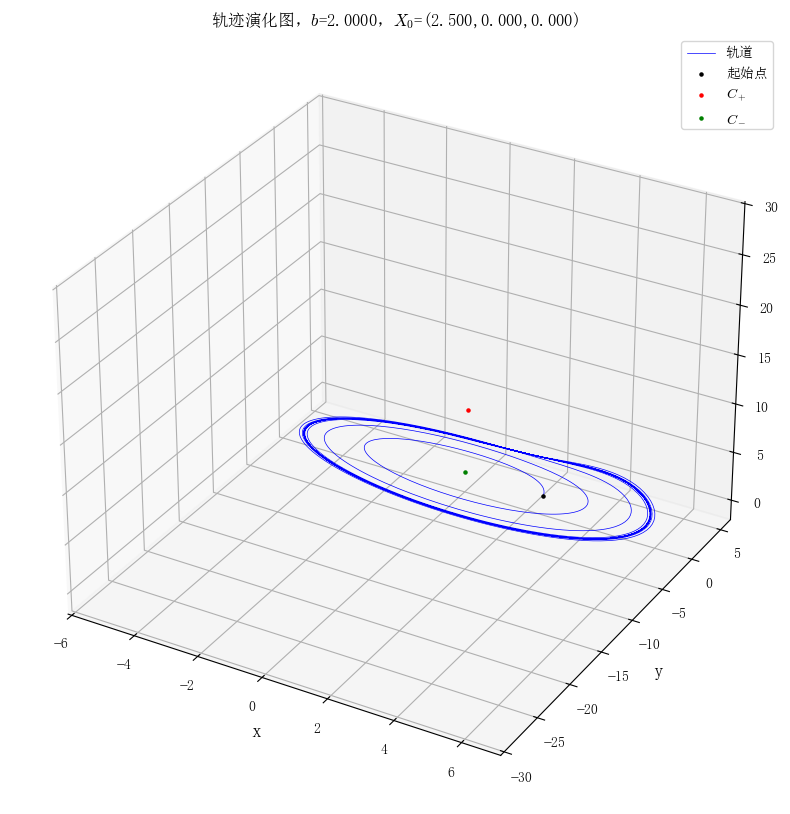

In [20]:
b = 2.0
a = 0.2
c = 5.7

t_max = 500
t_span = (0, t_max)
t_eval = np.linspace(t_span[0], t_span[1], 10000)
Cp, Cm = stable_pt(a,b,c)
X0 = np.array([2.5,0.,0.])
def solve_eq(t, u, a, b, c):
    x, y, z = u
    return [-y-z, x+a*y, b+z*(x-c)]

solution = scipy.integrate.solve_ivp(
    fun=solve_eq,
    t_span=t_span,
    y0=X0,
    args=(a, b, c),
    dense_output=True,
    t_eval=t_eval
)
x, y, z = solution.y
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue', label="轨道")
ax.scatter(*X0, c='k', s=5, label="起始点")
ax.scatter(*Cp, c='r', s=5, label="$C_+$")
ax.scatter(*Cm, c='g', s=5, label="$C_-$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"轨迹演化图，$b$={b:.4f}，$X_0$=({X0[0]:.3f},{X0[1]:.3f},{X0[2]:.3f})")
display_inline(fig)

可以发现，上面的 $b$ 都基本在混沌和周期的“边缘”（或者说最终轨道所在区域有一定“宽度”，若宽度更小可以认为是周期的，若更大则可以认为是混沌的）.

当然，上面的判断是非常粗糙的，因为我们很难判断其中的轨迹是暂态过程还是最后的收敛轨道. 我们需要通过更精准的方式来说明，这里仅使用庞加莱截面来说明. (受限于时间这里不尝试通过 Lorenz Map 来分析).

## 庞加莱截面

### 计算原理

首先从前面的轨迹图在整个 $b$ 的取值范围内变化的动画可以看出，所有的轨迹都会穿过 $x=0$ 的平面，因此我们选取的截面是 $x=0$（非常好计算和判断）.

同时，由于庞加莱截面只关系“穿过”截面的过程，也就是迭代前后两点在面的两侧，而其他点的具体值其实是不关心的，因此这里我们不使用 `scipy` 的 ODE 求解器（因为其必须记录所有的轨迹点，吃内存），而是自己手动实现一个 4 阶的定步长 Runge-Kutta 求解器（RK4）. 具体而言，对于方程 $\dot{X} = f(X)$（标准形式的 RK4 $f$ 与 $t$ 可能有关，这里无关，因此下面涉及 $f(t)$ 的部分略去），从 $X(t)$ 到 $X(t+dt)$:

- $k_1 = f(X(t))$
- $k_2 = f(X(t) + dt/2 \cdot k_1)$
- $k_3 = f(X(t) + dt/2 \cdot k_2)$
- $k_4 = f(X(t) + dt \cdot k_3)$
- $X(t+dt) = dt / 6 \cdot (k_1 + 2 k_2 + 2 k_3 + k_4) + X(t)$

因此，整个的计算庞加莱截面的过程如下：

1. 设定初始值，通过 RK4 迭代 $n_{\text{warm}}$ 次，去除暂态
2. 继续通过 RK4 迭代，每一次迭代判断是否满足 $X(t).x<0$ 且 $X(t+dt).x>0$，是则从 $-x \to +x$ 穿过了 $x=0$，跳转第 3 步，否则继续迭代.
3. 在 $X(t)$ 和 $X(t+dt)$ 之间进行一次线性插值，得到穿过 $x=0$ 的点坐标，并记录，具体而言：
$$ \begin{aligned}
s &= \frac{0-X(t).x}{X(t+dt).x-X(t).x} \\
X_{\text{交}} &= X(t) + s X(t+dt)
\end{aligned} $$
4. 继续迭代，直到收集足够多点或达到足够多次数

上述计算过程的一个加速小技巧是设定本身就比较靠近最终轨道的初始值，这样前面的暂态过程比较短，计算比较方便，下面统一取 $X_0 = (2.5,0,0)$

上述过程得到的计算庞加莱截面的函数如下：

In [21]:
@nb.njit()
def rossler_poincare(b, a, c, dt, n_warm, n_search, max_pt=100, X0=np.array([0.,0.,0.])):
    def df(X,a,b,c):
        return np.array([-X[1]-X[2],
                     X[0]+a*X[1],
                     b+X[2]*(X[0]-c)])
    X = X0.copy()
    for _ in range(n_warm):
        k1 = df(X, a, b, c)
        k2 = df(X + 0.5 * dt * k1, a, b, c)
        k3 = df(X + 0.5 * dt * k2, a, b, c)
        k4 = df(X + dt * k3, a, b, c)
        X += (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    pts = np.empty((n_search, 2))
    npt = 0
    x0 = 0.

    for _ in range(n_search):
        X_old = X.copy()
        k1 = df(X, a, b, c)
        k2 = df(X + 0.5 * dt * k1, a, b, c)
        k3 = df(X + 0.5 * dt * k2, a, b, c)
        k4 = df(X + dt * k3, a, b, c)
        X += (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        x_old = X_old[0]
        x_new = X[0]
        if x_old < x0 and x_new >= x0:
            s = (x0 - x_old) / (x_new - x_old)
            if npt < max_pt:
                pts[npt] = (X_old + s * (X - X_old))[1:]
                npt += 1
            else:
                break
    return pts[:npt]

下面我们就不同特殊值绘制庞加莱截面，查看具体情况.

### $b=0.5$（混沌代表）

对于混沌区（典型为 $b=0.5$），其庞加莱截面为

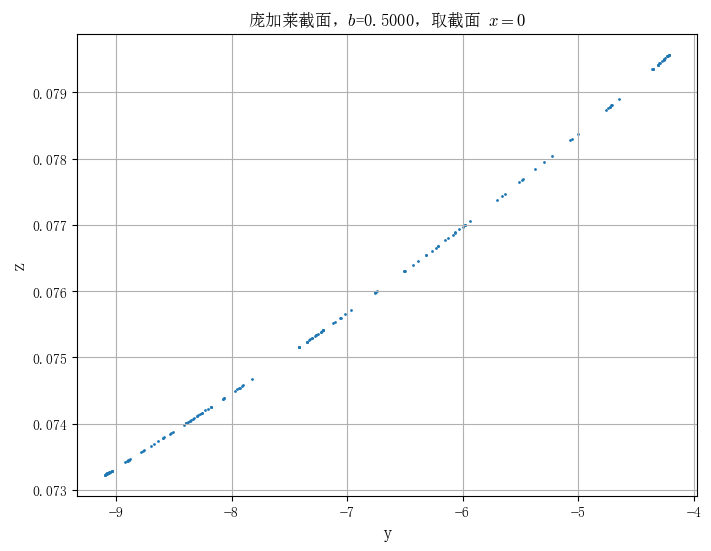

In [22]:
b = 0.5
a = 0.2
c = 5.7

dt = 0.01
n_warm = 50000
n_search = 100000

X0 = np.array([2.5,0.,0.])
pts = rossler_poincare(b, a, c, dt, n_warm, n_search, max_pt=5000, X0=X0)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pts[:,0], pts[:,1], s=1)
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title(f"庞加莱截面，$b$={b:.4f}，取截面 $x=0$")
ax.grid()
display_inline(fig)

可以看到，对于混沌区，其庞加莱截面具有非常多的点，且出现一些“连续的”区域，这说明每次轨迹从负到正经过 $x=0$ 时位置会有些些许的不同，导致轨道没有周期性，这是符合我们对混沌的预期的.

### $b=1.3$（周期轨道代表）

对于周期轨道（典型为 $b=1.3$），其庞加莱截面为：

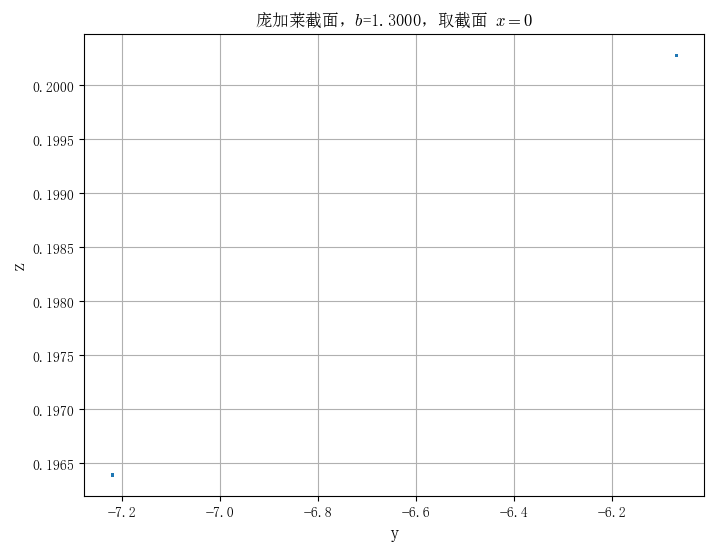

In [23]:
b = 1.3
a = 0.2
c = 5.7

dt = 0.01
n_warm = 50000
n_search = 100000

X0 = np.array([2.5,0.,0.])
pts = rossler_poincare(b, a, c, dt, n_warm, n_search, max_pt=5000, X0=X0)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pts[:,0], pts[:,1], s=1)
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title(f"庞加莱截面，$b$={b:.4f}，取截面 $x=0$")
ax.grid()
display_inline(fig)

可以看到，对于周期轨道，其有且只有有限个点（在这里对应两个点，也就是每绕两圈回到起始位置，是一个周期二轨道，和前面通过轨迹图的分析相同），也就是每次轨迹从负到正经过 $x=0$ 时位置相同，体现了轨道的周期性，这是符合我们对周期轨道的预期的.

### $b=0.3$ 附近（分界处）

对于临界附近（取 $b=0.295$ 和 $b=0.30$），其庞加莱截面为：

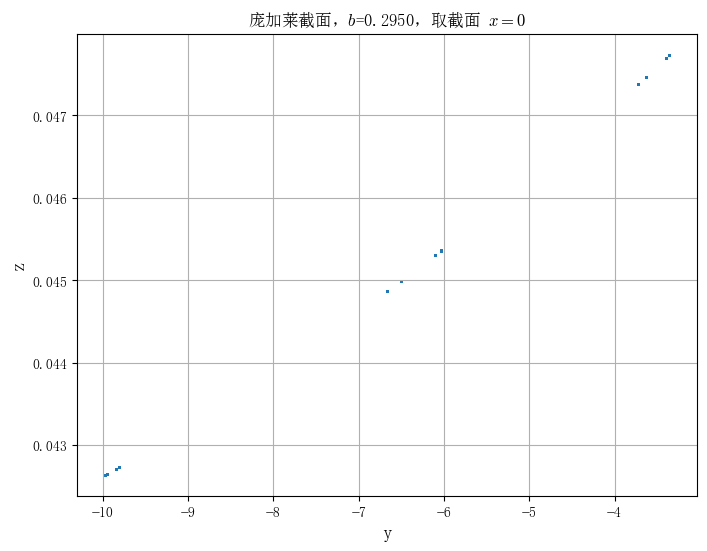

In [24]:
b = 0.295
a = 0.2
c = 5.7

dt = 0.01
n_warm = 50000
n_search = 100000

X0 = np.array([2.5,0.,0.])
pts = rossler_poincare(b, a, c, dt, n_warm, n_search, max_pt=5000, X0=X0)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pts[:,0], pts[:,1], s=1)
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title(f"庞加莱截面，$b$={b:.4f}，取截面 $x=0$")
ax.grid()
display_inline(fig)

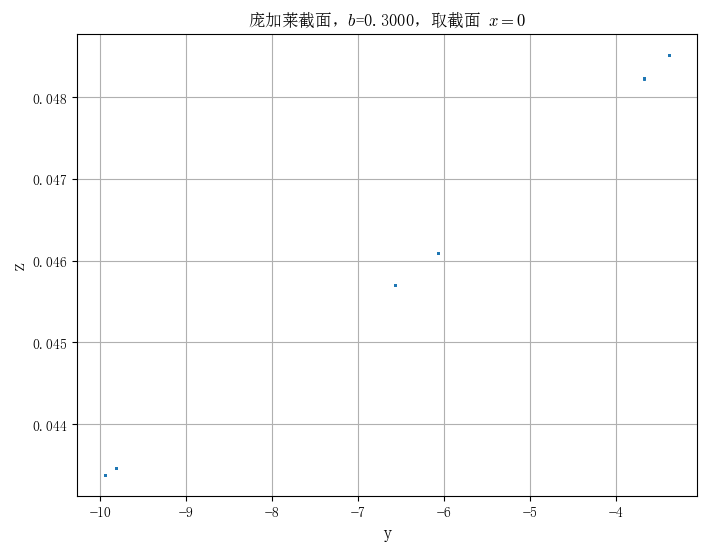

In [25]:
b = 0.30
a = 0.2
c = 5.7

dt = 0.01
n_warm = 50000
n_search = 100000

X0 = np.array([2.5,0.,0.])
pts = rossler_poincare(b, a, c, dt, n_warm, n_search, max_pt=5000, X0=X0)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pts[:,0], pts[:,1], s=1)
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title(f"庞加莱截面，$b$={b:.4f}，取截面 $x=0$")
ax.grid()
display_inline(fig)

对比两个庞加莱截面，可以发现，在分界处，原先的多个点随着 $b$ 增大“汇聚”成一个点，对于上面过程，其从 12 个点变成 6 个点，也就是每两个点收缩成一个点，呈现某种“倍周期收缩”（倍周期分叉的反向）

### 整个 $b$ 取值范围

现在我们计算整个 $b$ 的取值范围内的庞加莱截面，并将 $b$ 作为 $x$ 轴，庞加莱截面作为 $y-z$ 平面，从个绘制整个 $b$ 取值范围内的庞加莱截面. 

> 下面 Cell 需要运行较长时间，同时由于进行了多线程优化，计算时会占满所有的 CPU 核心.

In [26]:
@nb.njit(parallel=True, cache=True)
def rossler_poincare_nr(b_arr, a, c, dt, n_warm, n_search, max_pt=500, X0=np.array([1.,1.,1.])):
    n_r = len(b_arr)
    results = nb.typed.List() # 告诉 JIT 这里结果的类型
    for _ in range(n_r):
        results.append(np.empty((0, 2), dtype=np.float64))
    for i in nb.prange(n_r): # 多线程并行计算
        b_val = b_arr[i]
        results[i] = rossler_poincare(b_val, a, c, dt, n_warm, n_search, max_pt, X0)
    return results

In [27]:
b_arr = np.linspace(0.2, 2.0, 1000)
a = 0.2
c = 5.7

dt = 0.01
n_warm = 100000
n_search = 20000

max_pt = 5000
X0 = np.array([2.5,0.,0.])

poincare_res = rossler_poincare_nr(b_arr, a, c, dt, n_warm, n_search, max_pt=max_pt, X0=X0)

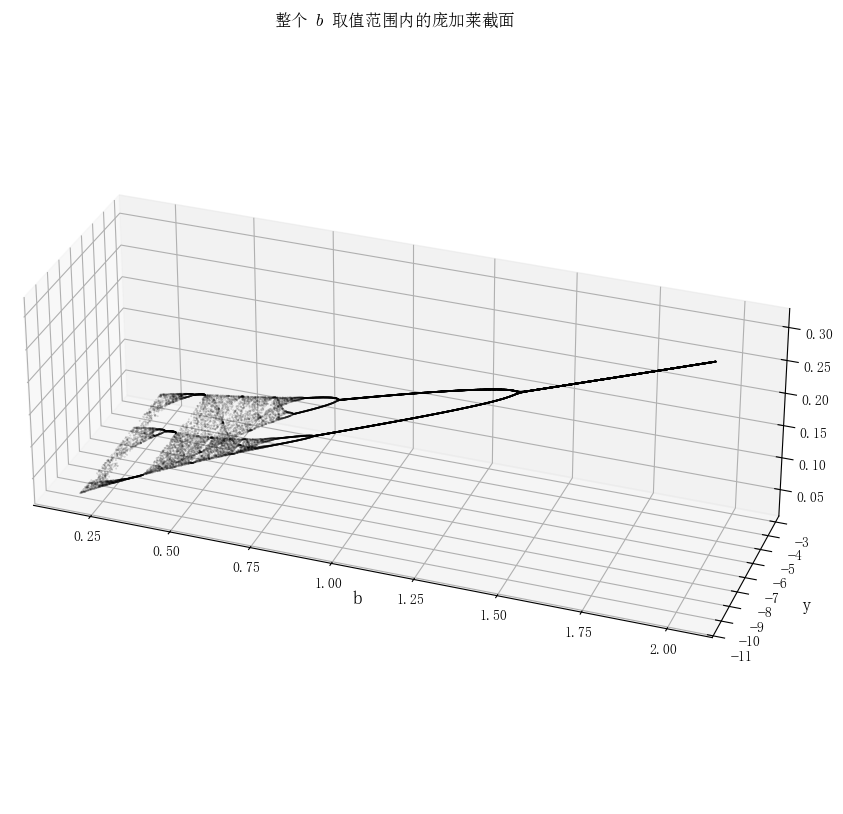

In [28]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(b_arr)):
    b_plot = np.ones_like(poincare_res[i][:,0]) * b_arr[i]
    ax.scatter(b_plot, poincare_res[i][:,0], poincare_res[i][:,1], c='k', s=0.1, alpha=0.2)
ax.set_box_aspect((3,1,1))
ax.view_init(30, -70)
ax.set_xlabel('b')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("整个 $b$ 取值范围内的庞加莱截面")
display_inline(fig)

可以在整个 $b$ 取值范围内，其庞加莱截面呈现某种分叉的分形结构，类似之前一维迭代系统的分叉图.

三维图形不容易分析，我们将其投影到 $b-y$ 平面.

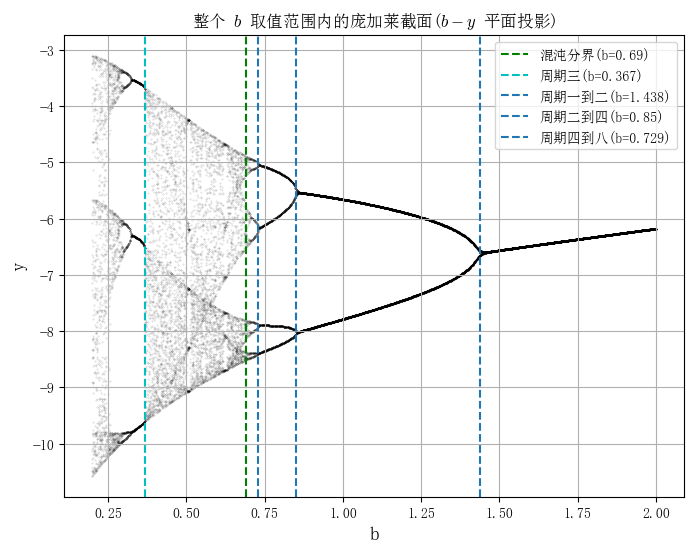

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(b_arr)):
    b_plot = np.ones_like(poincare_res[i][:,0]) * b_arr[i]
    ax.scatter(b_plot, poincare_res[i][:,0], c='k', s=0.1, alpha=0.2)
ax.axvline(0.69, color='g', linestyle='--', lw=1.5, label="混沌分界(b=0.69)")
ax.axvline(0.367, color='c', linestyle='--', lw=1.5, label="周期三(b=0.367)")
ax.axvline(1.438, linestyle='--', lw=1.5, label="周期一到二(b=1.438)")
ax.axvline(0.85, linestyle='--', lw=1.5, label="周期二到四(b=0.85)")
ax.axvline(0.729, linestyle='--', lw=1.5, label="周期四到八(b=0.729)")
ax.set_xlabel('b')
ax.set_ylabel('y')
ax.grid()
ax.legend()
ax.set_title("整个 $b$ 取值范围内的庞加莱截面($b-y$ 平面投影)")
display_inline(fig)

可以看到，整个图形同样类似分叉图，有倍周期分叉，有周期三，有混沌，因此我们完全可以使用前面分析一维系统分叉图的理论来分析这个系统的庞加莱截面随 $b$ 的变化.

同时，我们可以看到，在 $b\approx0.3$ 附近，短暂出现类似周期三的轨道，在前面 $b=0.3$ 的庞加莱截面的绘制中，出现了 6 个点，是因为取得点不够精准，准确的说是取小了，导致出现了周期三到周期六的倍周期分叉.

同时，由于临界慢化现象，在分叉点附近出现了“杂带”(放大容易看见)，这也导致了前面我们通过轨迹图分析是错误地判断是混沌，但这实际上是系统还没有收敛到周期轨道（收敛太慢）导致的“错觉”. 通过轨迹“密度”是无法判断其是收敛太慢导致的暂态过程过长，轨迹变密还是出现了混沌，因此通过轨迹图的判断是比较粗糙的判断.

另一方面，这也能解释为什么前面没有观察到周期四周期八等轨道，因为其分叉点更密集，更靠近分叉点，因此有临界慢化现象，使得通过轨迹图不容易判断最后是周期轨道还是混沌.

同时，我们也可以知道，前面我们误以为是混沌和周期的分界（也就是 $b=0.85$, $b=1.42$）实际上都对应了倍周期分叉点，$b=8.5$ 对应了周期二到周期四的分叉，$b=1.42$ 对应了周期一到周期二的分叉.

---

通过分叉图，我们可以大概判断几个特殊的点如下（直接通过放大图片人工选点，受限于时间和可能的计算量，这里不进行进一步二分查找提高精度）：

- 周期一到周期二：$b \approx 1.438$
- 周期二到周期四：$b \approx 0.85$
- 周期四到周期八：$b \approx 0.729$
- 混沌分界：$b \approx 0.69$
- 周期三：$b \approx 0.367$

我们也可以通过三个倍周期分叉点粗略估计费根鲍姆常数（当然，由于费根鲍姆常数是经 $n\to\infty$ 的极限后得到的，这里的估计非常粗糙）：

$$\delta \approx \frac{1.438-0.85}{0.85-0.729} \approx 4.859, \quad \frac{|\delta - \delta_0|}{\delta_0} = 4\% $$

我们有理由认为，对于这个系统，其费根鲍姆常数和 Logstic Map 相同（当然需要更高精度计算验证）. 这也说明费根鲍姆常数是普世的，即使不是一维系统也会出现.

综上，通过庞加莱截面，我们更精确地判断了混沌出现的位置，以及系统的分叉行为，用更准确的手段分析系统的收敛行为，同时也解释了前面轨迹图随 $b$ 的变化.


## 最大李雅普诺夫指数

### 计算原理

这里我们采用和前面一维系统的数值求解李雅谱诺夫指数相同的思路. 在稳态过程取点 $X(t)$ 加上微扰 $X'(t)=X(t)+\delta_0$，迭代一个较小的时间，计算 $\delta_t = |X'-X|$根据李雅普诺夫指数的定义，有：

$$ \delta_t = \delta_0 \mathrm{e}^{\lambda t} $$

因此：

$$ \lambda = \frac{1}{t} \ln \frac{\delta_t}{\delta_0} $$

同样地，上面式子只在 $\delta_t \ll 1$ 成立，因此需要一定步数后重新“缩放”一下.

因此，我们可以得到计算给定参数 $b$ 的李雅普诺夫指数如下：

1. 从给定初始值开始，使用 RK4 迭代一定步数，去掉暂态过程
2. 取 $X$ 和 $X'=X+\delta$，对 $X$ 和 $X'$ 同时使用 RK4 迭代某个小步数 $n_{\text{renorm}}$
3. 计算 $\delta_t = |X'-X|$，计算 $\ln (\delta_t / \delta)$ 并累加到 $S$ 中，重新缩放两点距离使得为 $\delta_0$，回到第 2 步，直至达到指定采样次数
4. $\lambda = S / T_{\text{sample}}$，其中 $T_{\text{sample}}$ 是整个采样时间.

对参数 $b$ 在所有取值范围内采样，并多线程计算，从而可以得到整个 $b$ 取值内的最大李亚谱诺夫指数曲线.

上述过程的函数实现如下：

In [30]:
@nb.njit()
def rossler_lyapunov_max_single(b, a, c, dt, n_warm, n_sample, n_renorm, X0=np.array([0.,0.,0.]), Delta0=np.array([1e-8,0.,0.]), offset=1e-300):
    def df(X,a,b,c):
        return np.array([-X[1]-X[2],
                     X[0]+a*X[1],
                     b+X[2]*(X[0]-c)])
    X = X0.copy()
    for _ in range(n_warm):
        # X = X + df(X, a, b, c) * dt
        k1 = df(X, a, b, c)
        k2 = df(X + 0.5 * dt * k1, a, b, c)
        k3 = df(X + 0.5 * dt * k2, a, b, c)
        k4 = df(X + dt * k3, a, b, c)
        X += (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

    lambda_sum = 0.
    n_cycles = n_sample // n_renorm
    X_p = X + Delta0
    for cycle in range(n_cycles):
        for _ in range(n_renorm):
            # X = X + df(X, a, b, c) * dt
            # X_p = X_p + df(X_p, a, b, c) * dt
            # RK4
            k1 = df(X, a, b, c)
            k2 = df(X + 0.5 * dt * k1, a, b, c)
            k3 = df(X + 0.5 * dt * k2, a, b, c)
            k4 = df(X + dt * k3, a, b, c)
            X += (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
            k1 = df(X_p, a, b, c)
            k2 = df(X_p + 0.5 * dt * k1, a, b, c)
            k3 = df(X_p + 0.5 * dt * k2, a, b, c)
            k4 = df(X_p + dt * k3, a, b, c)
            X_p += (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

        Delta = X - X_p
        d0 = np.linalg.norm(Delta0)
        d = np.linalg.norm(Delta)
        lambda_sum += np.log(np.abs(d/d0) + offset) # 防止 log(0)
        X_p = X + (Delta / d) * np.linalg.norm(Delta0)
    return lambda_sum / (n_cycles * n_renorm * dt)

@nb.njit(parallel=True, cache=True)
def rossler_lyapunov_max(b_arr, a, c, dt, n_warm, n_sample, n_renorm, X0=np.array([0.,0.,0.]), Delta0=np.array([1e-8,0.,0.]), offset=1e-300):
    n_r = len(b_arr)
    lyapunov_arr = np.zeros(n_r, dtype=np.float64)
    for i in nb.prange(n_r):
        lyapunov_arr[i] = rossler_lyapunov_max_single(b_arr[i], a, c, dt, n_warm, n_sample, n_renorm, X0, Delta0, offset)
    return lyapunov_arr

### 整个 $b$ 的取值范围内的最大李亚谱诺夫指数

> 下面 Cell 需要运行较长时间，同时由于进行了多线程优化，计算时会占满所有的 CPU 核心.

In [31]:
a = 0.2
c = 5.7

b_arr = np.linspace(0.2, 2.0, 1000)

dt = 0.01
n_warm = 10000
n_sample = 50000
n_renorm = 10

X0 = np.array([2.5,0.,0.])
res_mle = rossler_lyapunov_max(b_arr, a, c, dt, n_warm, n_sample, n_renorm, X0=X0)

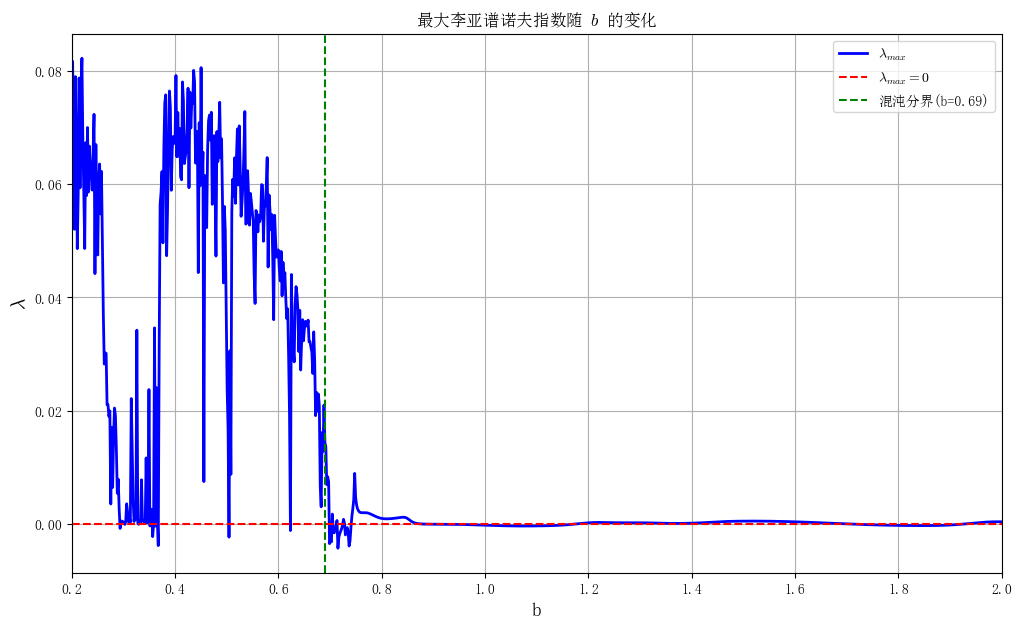

In [32]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(b_arr, res_mle, lw=2, color='b', label='$\\lambda_{max}$')
ax.axhline(0, color='red', linestyle='--', lw=1.5, label='$\\lambda_{max}=0$')
ax.axvline(0.69, color='g', linestyle='--', lw=1.5, label="混沌分界(b=0.69)")
ax.set_xlim(b_arr.min(), b_arr.max())
ax.legend()
ax.grid()
ax.set_xlabel("b")
ax.set_ylabel("$\\lambda$")
ax.set_title("最大李亚谱诺夫指数随 $b$ 的变化")
display_inline(fig)

图中可以看到，在混沌区域，其最大李雅普诺夫指数大于 $0$，这是符合我们预期的，但是在各个周期轨道处（$b\approx 3.67$ 周期三处，$b>0.69$ 非混沌区），其最大李雅普诺夫指数基本为 $0$（忽略由于数值计算和临界慢化导致的误差）. 这个现象和一维的情况不同. 在之前对一维系统的分析中，当轨迹是周期时其李雅普诺夫指数应该是小于 $0$ 的. 这里需要进一步解释说明.

### 为何有周期轨道时最大李雅普诺夫指数为 $0$

现在我们来解释为何有周期轨道时最大李亚谱诺夫指数为 $0$. 这里我认为是因为对于 Rossler 等连续的系统，轨迹的连续性要求其一定有一个方向的李雅普诺夫指数为 $0$. 

考虑如下的一个特殊的情况，若我们的微扰 $\delta$ 方向是速度方向，也就是某一初始时刻 $t$ 时设的微扰 $delta_0 = V(t)dt$, 即 $X'=X+Vdt$, 其相当于是在 $X$ 轨迹的多经过 $dt$ 后 ，因此轨迹演化时两个点经过的轨迹相同，因此最后两个点的位置为 $X(t+\Delta t)$ 和 $X(t+\Delta t) + V(t+\Delta t) dt$，即 $\delta_t = V(t+\delta t) dt$，因此：

$$ \lambda = \frac{1}{\Delta t} \ln \left| \frac{V(t+\Delta t)}{V(t)} \right| $$

由于轨迹是有限的，且点一直是运动的（没有停留在不动点），因此 $\ln$ 内一定是一个有限值，当 $\Delta t \to \infty$ 后 $\lambda \to 0$. 

当然，上述过程是一个比较不严谨的过程，可能需要更准确的描述和分析. 但大概告诉了我们为何即使有周期轨道时最大李亚谱诺夫指数为 $0$.

若要希望得到类似一维系统的李雅普诺夫指数图，需要详细计算三个正交方向的李亚谱诺夫指数.

## 李雅普诺夫指数

### 计算原理

现在我们需要计算更详细的李雅普诺夫指数（不只是最大李雅普诺夫指数，而是三个李雅普诺夫指数），这需要修改前面的计算过程. 具体而言，我们现在要追踪三个正交方向的扰动向量的变化. 这里我们设三个扰动向量分别是 $\Delta_1, \Delta_2, \Delta_3$，且这三个向量正交. 我们记录这三个向量的模长随时间的变化. 从而得到三个李雅普诺夫指数指数，具体而言，对于每一个向量，我们有：

$$ |\Delta_i(t+\Delta t)| = |\Delta_i (t)| \mathrm{e}^{\lambda_i \Delta t} $$

因此：

$$ \lambda_i = \frac{1}{\Delta t} \ln \frac{|\Delta_i(t+\Delta t)|}{|\Delta_i(t)|} , i=1,2,3$$

同时，这三个向量可以拼接成一个 3x3 矩阵 $Q=[\Delta_1, \Delta_2,\Delta_3]$.

现在我们要计算经过一个 $dt$ 后这三个向量的变化，这里很容易想到的就是通过作用 Jacobian 矩阵，具体而言， Jacobian 矩阵描述了某一点经过函数 $f$ 演化 $dt$ 后该点周围邻域的变化过程. 因此，给定位于邻域的任意一个小向量 $X$，其演化 $dt$ 后就是 $X + J X dt$.

因此，我们可以得到矩阵 $Q$ 的更新式子：$Q(t+dt) = Q(t) + J(X) Q(t) dt$

当然，上面的式子是最简单的欧拉法的更新式子，这里我们同样使用 RK4 来计算. 根据 RK4 的思想，我们可以写下更新过程（此过程我没有证明或者从书中找到推导，我问了 Gemini AI，其认为是对的，且经过后面的计算应该是对的）

- $J_1 = J(X(t)) Q(t),\ k_1 = f(X(t))$
- $J_2 = J(X(t) + dt/2 \cdot k_1 ) Q(t),\ k_2 = f(X(t) + dt/2 \cdot k_1)$
- $J_3 = J(X(t) + dt/2 \cdot k_2 ) Q(t),\ k_3 = f(X(t) + dt/2 \cdot k_2)$
- $J_4 = J(X(t) + dt \cdot k_3 ) Q(t),\ k_4 = f(X(t) + dt \cdot k_3)$
- $Q(t+dt) = dt / 6 \cdot (J_1 + 2 J_2 + 2 J_3 + J_4) + Q(t)$
- $X(t+dt) = dt / 6 \cdot (k_1 + 2 k_2 + 2 k_3 + k_4) + X(t)$

同时，根据课后的讨论我们知道，在演化一段时间后，$Q$ 中 3 个向量可能不再正交（随着流进行拉伸和旋转），因此除了需要类似前面的“缩放”，还需要进行正交化. 也就是这里要同时进行正交和归一的操作. 另外，由于我们还需要计算李亚谱诺夫指数，我们还需要得到正交归一后的向量相比正交化之前缩放了多少.

这里我们使用 QR 分解来快速实现上面功能，具体而言，QR 分解将任意矩阵 $A$ 进行正交归一得到 $A=QR$，其中 $Q$ 为正交归一化后的向量组成的矩阵，$R$ 为正交归一化的系数构成的矩阵，其是上三角的（根据 Gram-Schmidt 的过程，很显然每一次正交归一化只依赖前面的向量，因此必然是上三角的）. 同时，$R$ 中对角的元素表征了在新的基底 $Q$ 下表示 $A$ 的每个向量的“拉伸”长度.（忽略非正交的拉伸）

一个简单的示意图如下：

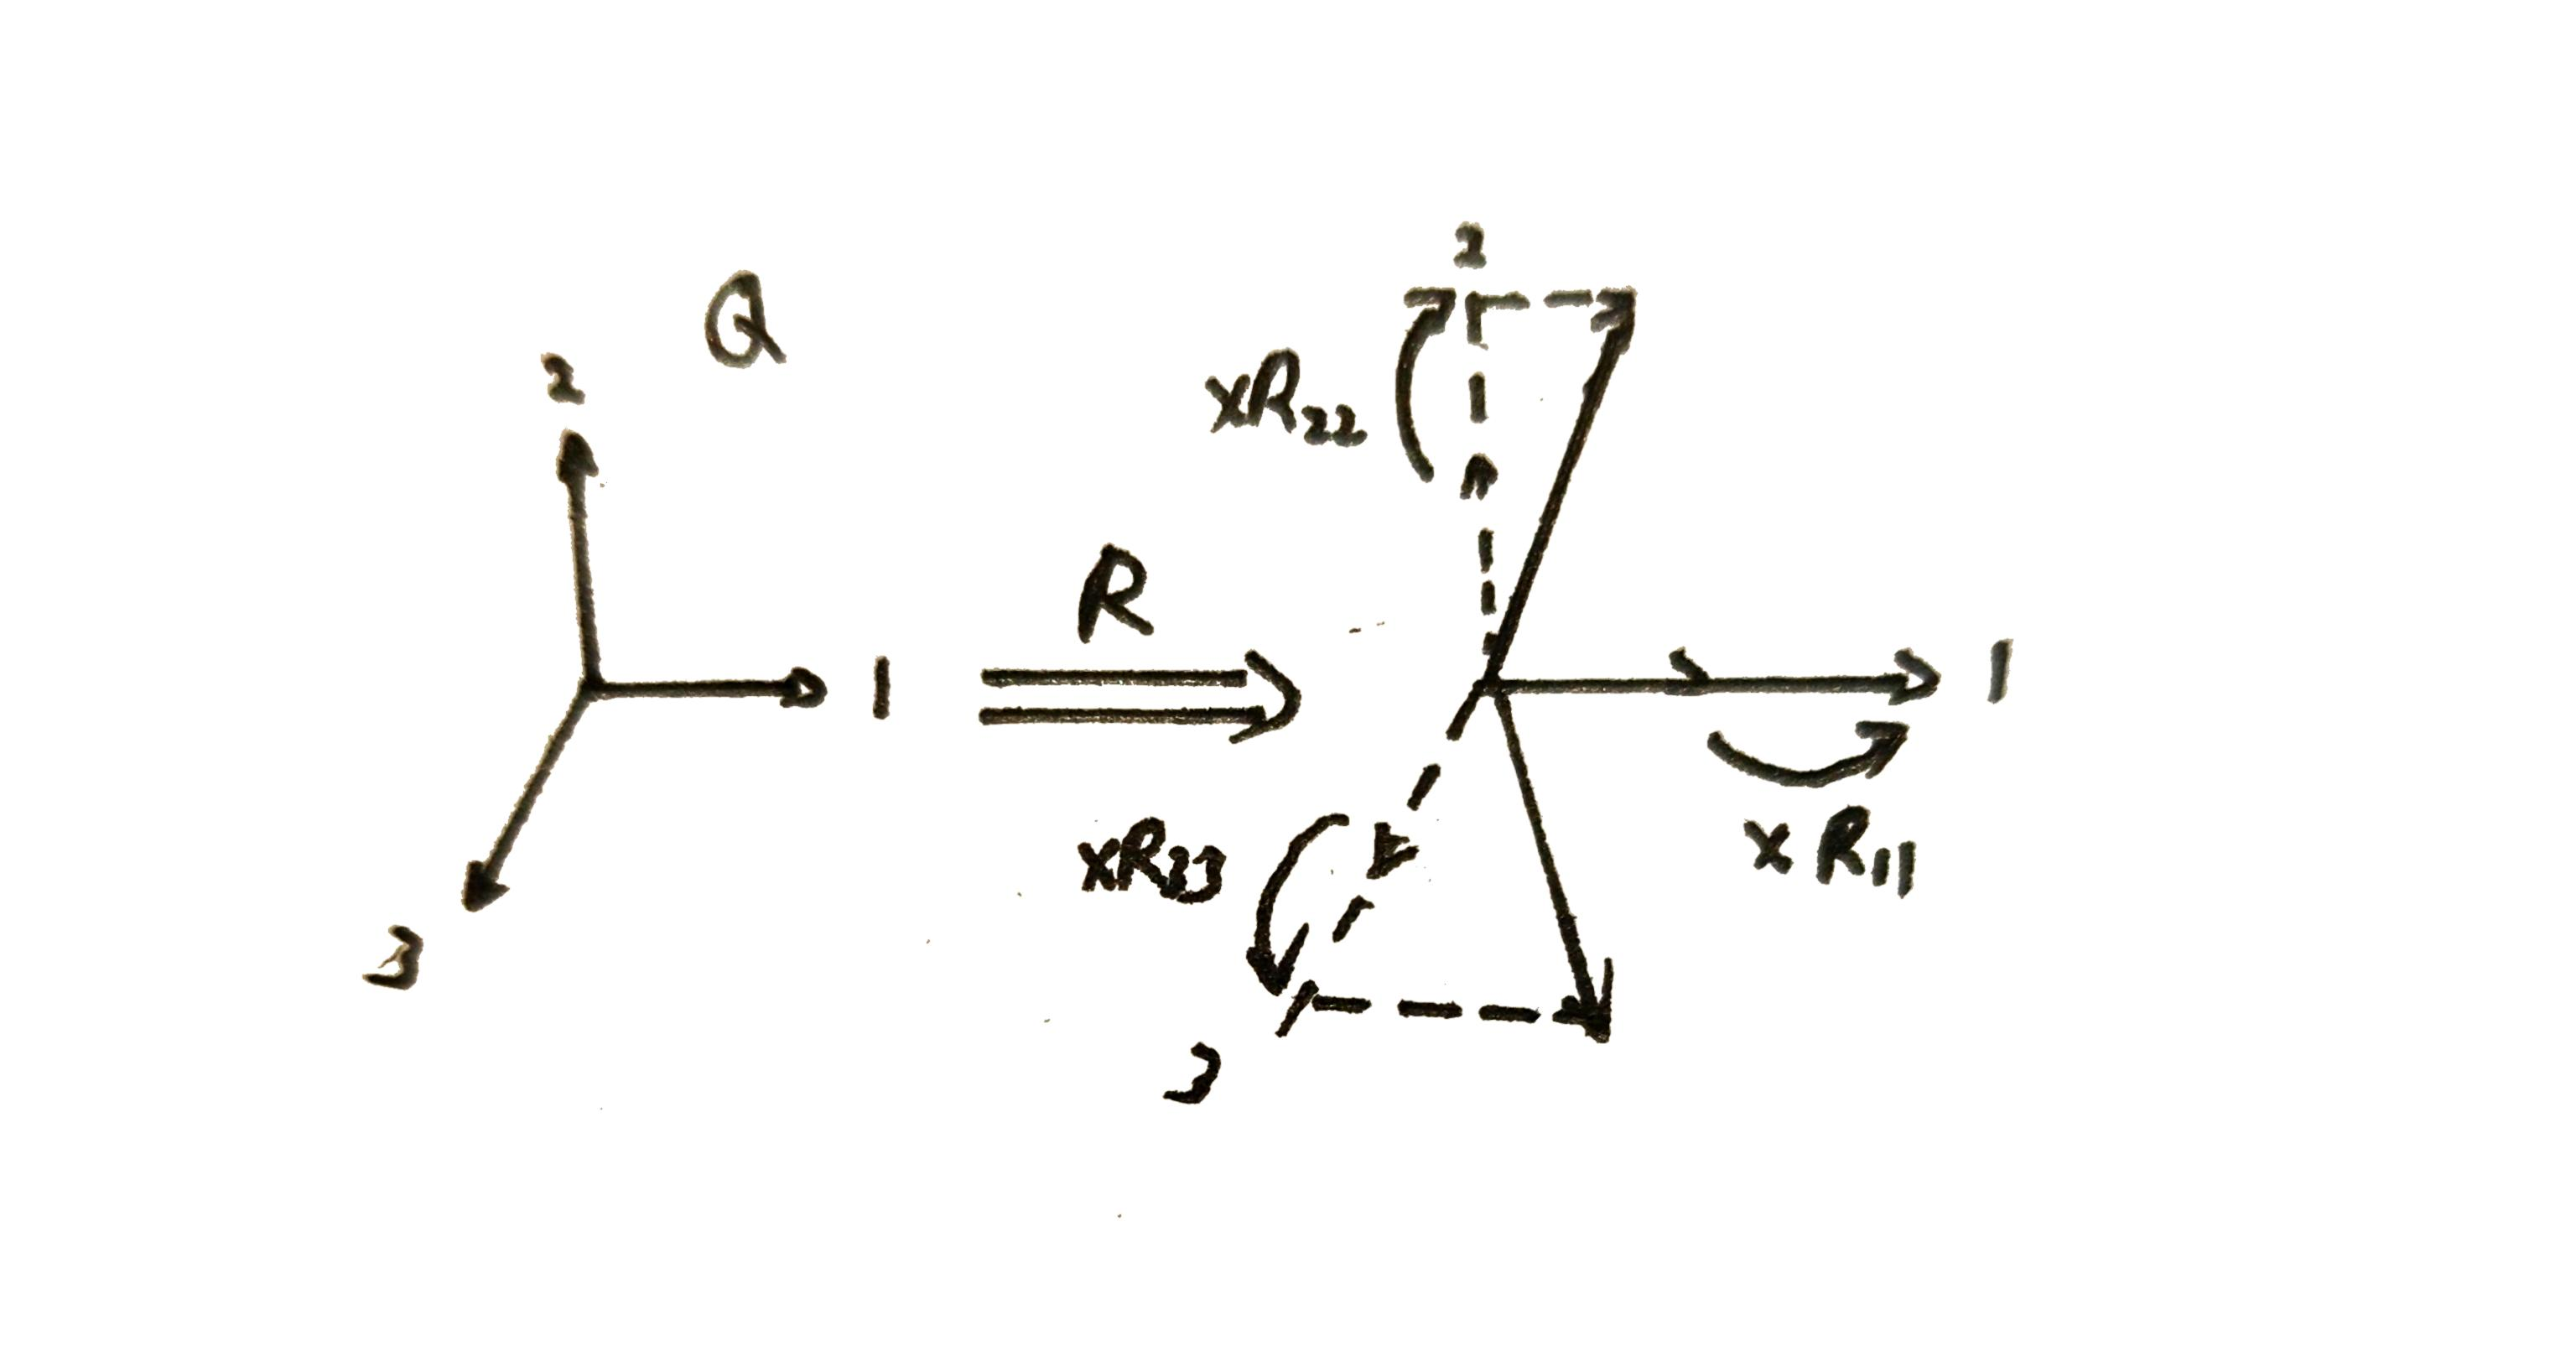

当然，有可能 QR 分解后 R 对角元素出现负数（对应扰动矢量归一化后发生了“翻转”），需要人工翻转回来.

综上，我们得到了一个计算三个李亚谱诺夫指数的方法：

1. 从给定初始值开始，使用 RK4 迭代一定步数，去掉暂态过程
2. 取 $X$ 和 $Q=I$（单位矩阵），对 $X$ 和 $Q$ 同时使用 RK4 迭代某个小步数 $n_{\text{renorm}}$
3. 对 $Q$ 进行 QR 分解，分解得到的 $Q'$ 替换 $Q$，分解得到的 $R$ 收集 $\ln |R_{11}|, \ln |R_{22}| , \ln |R_{33}|$，累加到 $S_1,S_2,S_3$ 中，回到第 2 步，直至达到指定采样次数. 
4. $\lambda_i = S_i / T_{\text{sample}}$，其中 $T_{\text{sample}}$ 是整个采样时间.

对参数 $b$ 在所有取值范围内采样，并多线程计算，从而可以得到整个 $b$ 取值内的李亚谱诺夫指数曲线.

上述过程的实现如下：

In [33]:
@nb.njit()
def rossler_lyapunov_single(b, a, c, dt, n_warm, n_sample, n_renorm, X0=np.array([0.,0.,0.]), offset=1e-300):
    def df(X,a,b,c):
        return np.array([-X[1]-X[2],
                     X[0]+a*X[1],
                     b+X[2]*(X[0]-c)])

    def jac(X,a,b,c):
        return np.array([[0., -1.,      -1.],
                         [1.,   a,       0.],
                         [X[2], 0., -c+X[0]]])
    X = X0.copy()
    for _ in range(n_warm):
        k1 = df(X, a, b, c)
        k2 = df(X + 0.5 * dt * k1, a, b, c)
        k3 = df(X + 0.5 * dt * k2, a, b, c)
        k4 = df(X + dt * k3, a, b, c)
        X += (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

    dim = len(X)
    Q = np.eye(dim)
    lambda_sum = np.zeros(dim)
    n_cycles = n_sample // n_renorm
    for cycle in range(n_cycles):
        for _ in range(n_renorm):
            X_old = X.copy()
            # X = X + df(X_old, a, b, c) * dt
            # Q = Q + dt * jac(X_old, a, b, c) @ Q
            k1 = df(X_old, a, b, c)
            k2 = df(X_old + 0.5 * dt * k1, a, b, c)
            k3 = df(X_old + 0.5 * dt * k2, a, b, c)
            k4 = df(X_old + dt * k3, a, b, c)
            X += (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

            J1 = jac(X_old, a, b, c) @ Q
            J2 = jac(X_old + 0.5 * dt * k1, a, b, c) @ (Q + 0.5 * dt * J1)
            J3 = jac(X_old + 0.5 * dt * k2, a, b, c) @ (Q + 0.5 * dt * J2)
            J4 = jac(X_old + dt * k3, a, b, c) @ (Q + dt * J3)
            Q += (dt / 6.0) * (J1 + 2 * J2 + 2 * J3 + J4)
        Q, R = np.linalg.qr(Q)
        Q = np.ascontiguousarray(Q) # C 数组和 Fortran 数组转换，加速
        diag_R = np.diag(R)
        Q[:, diag_R < 0] *= -1
        lambda_sum += np.log(np.abs(diag_R) + offset) # 防止 log(0)
    return lambda_sum / (n_cycles * n_renorm * dt)

@nb.njit(parallel=True, cache=True)
def rossler_lyapunov_nr(b_arr, a, c, dt, n_warm, n_sample, n_renorm, X0=np.array([0.,0.,0.]), offset=1e-300):
    n_r = len(b_arr)
    lyapunov_arr = np.zeros((n_r, len(X0)))
    for i in nb.prange(n_r):
        lyapunov_arr[i] = rossler_lyapunov_single(b_arr[i], a, c, dt, n_warm, n_sample, n_renorm, X0, offset)
    return lyapunov_arr

### 整个 $b$ 的取值范围内的李亚谱诺夫指数

> 下面 Cell 需要运行较长时间，同时由于进行了多线程优化，计算时会占满所有的 CPU 核心.

In [34]:
a = 0.2
c = 5.7

b_arr = np.linspace(0.2, 2.0, 1000)

dt = 0.01
n_warm = 10000
n_sample = 50000
n_renorm = 10

X0 = np.array([2.5,0.,0.])
res_les = rossler_lyapunov_nr(b_arr, a, c, dt, n_warm, n_sample, n_renorm, X0)

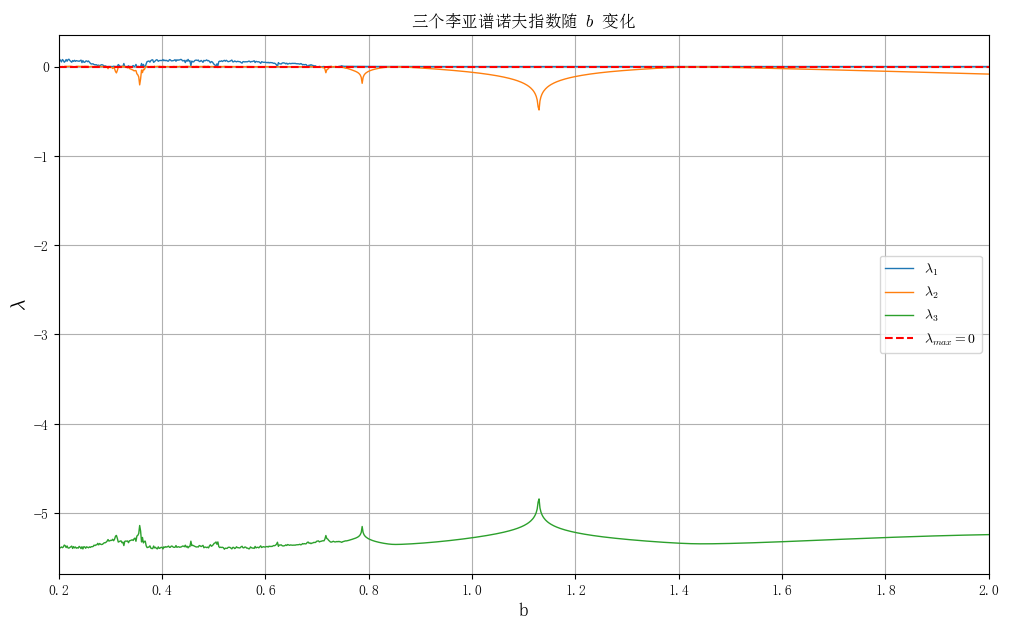

In [35]:
fig, ax = plt.subplots(figsize=(12, 7))
for i in range(3):
    ax.plot(b_arr, res_les[:,i], lw=1, label=f'$\\lambda_{i+1}$')
ax.axhline(0, color='red', linestyle='--', lw=1.5, label='$\\lambda_{max}=0$')
ax.set_xlim(b_arr.min(), b_arr.max())
ax.legend()
ax.grid()
ax.set_xlabel("b")
ax.set_ylabel("$\\lambda$")
ax.set_title("三个李亚谱诺夫指数随 $b$ 变化")
display_inline(fig)

上面图像中由于 $\lambda_3$ 和 $\lambda_1,\lambda_2$ 相差过大，导致画面比较白，我们修改一下，将负的 $\lambda_3$ 放到右轴.

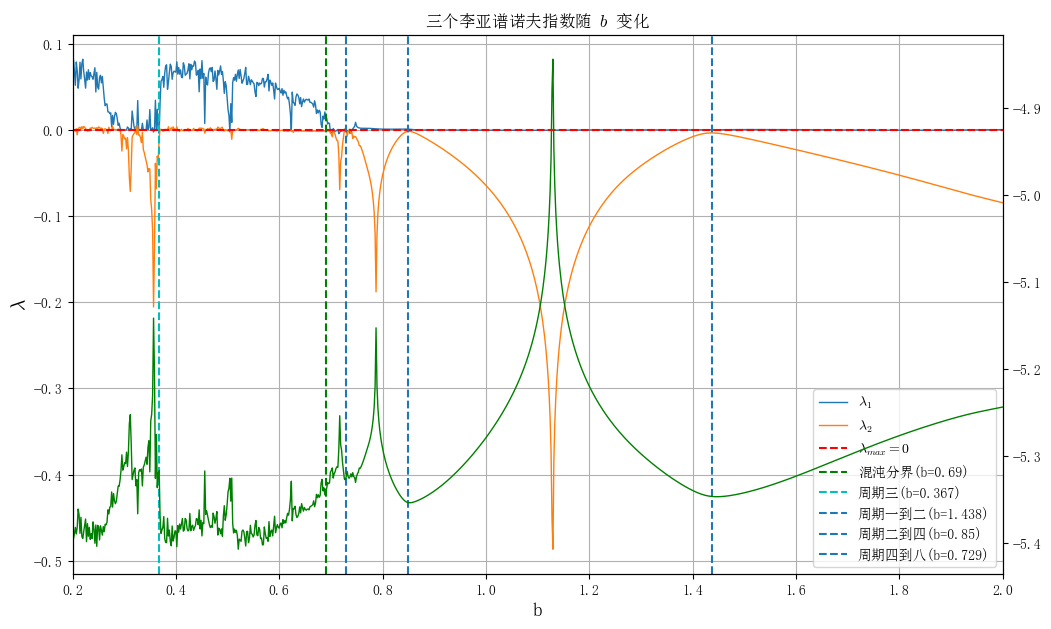

In [36]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
for i in range(2):
    ax.plot(b_arr, res_les[:,i], lw=1, label=f'$\\lambda_{i+1}$')
ax2.plot(b_arr, res_les[:,2], c='g', lw=1, label=f'$\\lambda_{2+1}$')
ax.axhline(0, color='red', linestyle='--', lw=1.5, label='$\\lambda_{max}=0$')
ax.axvline(0.69, color='g', linestyle='--', lw=1.5, label="混沌分界(b=0.69)")
ax.axvline(0.367, color='c', linestyle='--', lw=1.5, label="周期三(b=0.367)")
ax.axvline(1.438, linestyle='--', lw=1.5, label="周期一到二(b=1.438)")
ax.axvline(0.85, linestyle='--', lw=1.5, label="周期二到四(b=0.85)")
ax.axvline(0.729, linestyle='--', lw=1.5, label="周期四到八(b=0.729)")
ax.set_xlim(b_arr.min(), b_arr.max())
ax.legend()
ax.grid()
ax.set_xlabel("b")
ax.set_ylabel("$\\lambda$")
ax.set_title("三个李亚谱诺夫指数随 $b$ 变化")
display_inline(fig)

可以看到，对于第二大的 $\lambda$，其出现和一维系统李雅普诺夫指数类似的情况，当 $\lambda_2 = 0$ 时倍周期分叉.

同时，对于 $\lambda_2$，其也出现类似超稳定环对应的 $\lambda$ 极小值的情况. 通过放大图片，我们可以得到前三个超稳定环出现位置（同样受限于时间，这里不再进行二分查找细化）：

- $n=2: b \approx 1.13$
- $n=4: b \approx 0.7874$
- $n=8: b \approx 0.7175$

我们同样可以用上面的数据估计费根鲍姆常数（同样是非常粗糙的估计）：

$$\delta \approx \frac{1.13-0.7874}{0.7874-0.7175} \approx 4.90, \quad \frac{|\delta - \delta_0|}{\delta_0} = 5\% $$

我们有理由认为，对于这个系统，其可能也有某种超稳定环，且其计算得到的费根鲍姆常数和 Logstic Map 相同（当然需要更高精度计算验证）.

综上，我们通过李雅普诺夫指数进一步解释了前面庞加莱截面和轨道演化图得出的结论，并进一步指出此高维连续系统和前面一维系统的一些相似性.

## 结论

### 不动点分析

系统有两个不动点 $C_+,C_-$，不动点的坐标满足：

$$
C_{\pm} = \left( \frac{c}{2} \pm \frac{\sqrt{- 4 a b + c^{2}}}{2}, \  \frac{- c \mp \sqrt{- 4 a b + c^{2}}}{2 a}, \  \frac{c}{2 a} \pm \frac{\sqrt{- 4 a b + c^{2}}}{2 a}\right)
$$

两个不动点在整个 $b$ 变化范围内均不稳定，在附近轨道会旋转离开. 其中 $C_+$ 有两个 $\lambda>0$，一个 $\lambda<0$， $C_-$ 有两个 $\lambda<0$，一个 $\lambda>0$ 

### 轨道演化图

通过轨道演化图，我们验证了两个不动点确实都是不稳定不动点，同时发现：

- $b=0.3$ 短暂出现周期轨道
- $b=0.85$ 和 $b=1.42$ 附近系统出现变化

### 庞加莱截面

通过 RK4 + 在分界处线性插值，在整个 $b$ 取值范围内的庞加莱截面如下：

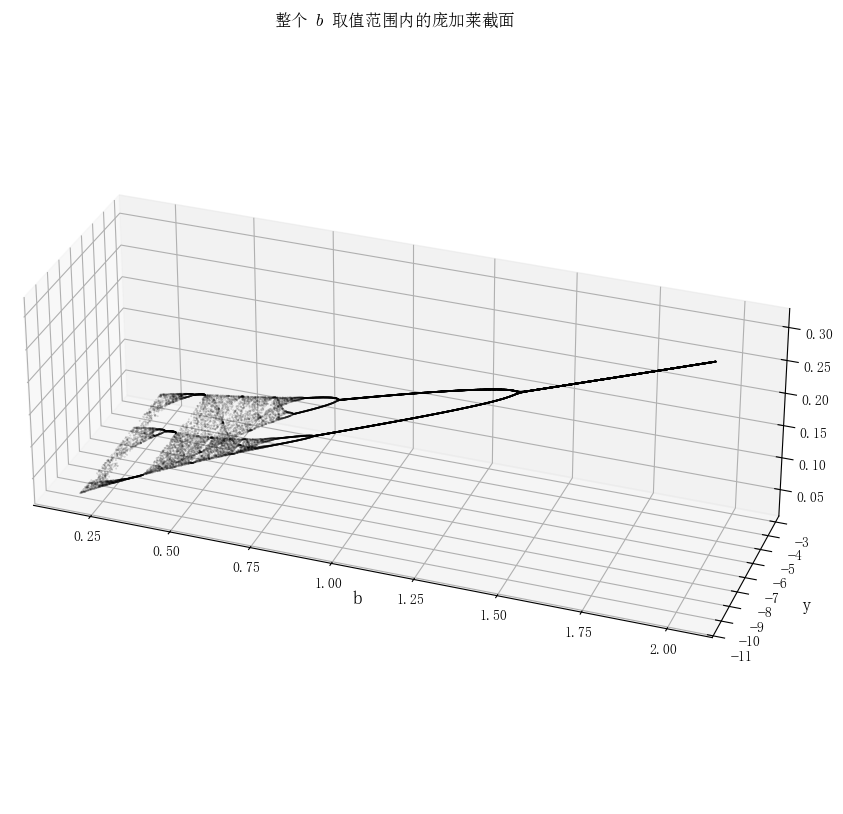

In [37]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(b_arr)):
    b_plot = np.ones_like(poincare_res[i][:,0]) * b_arr[i]
    ax.scatter(b_plot, poincare_res[i][:,0], poincare_res[i][:,1], c='k', s=0.1, alpha=0.2)
ax.set_box_aspect((3,1,1))
ax.view_init(30, -70)
ax.set_xlabel('b')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("整个 $b$ 取值范围内的庞加莱截面")
display_inline(fig)

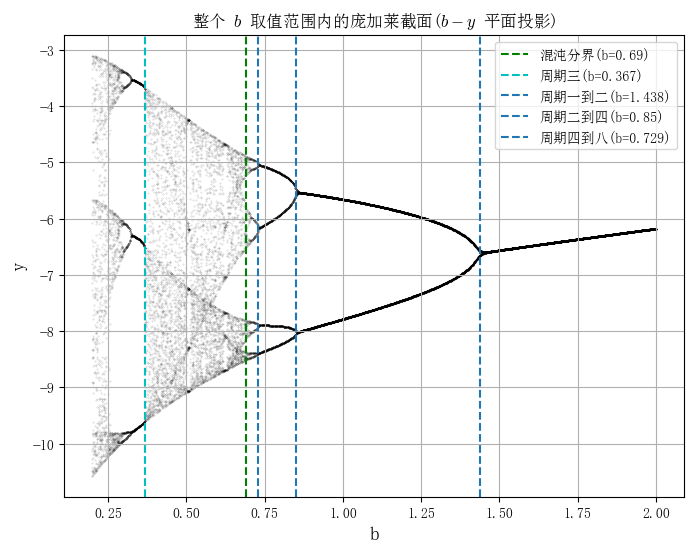

In [38]:
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(b_arr)):
    b_plot = np.ones_like(poincare_res[i][:,0]) * b_arr[i]
    ax.scatter(b_plot, poincare_res[i][:,0], c='k', s=0.1, alpha=0.2)
ax.axvline(0.69, color='g', linestyle='--', lw=1.5, label="混沌分界(b=0.69)")
ax.axvline(0.367, color='c', linestyle='--', lw=1.5, label="周期三(b=0.367)")
ax.axvline(1.438, linestyle='--', lw=1.5, label="周期一到二(b=1.438)")
ax.axvline(0.85, linestyle='--', lw=1.5, label="周期二到四(b=0.85)")
ax.axvline(0.729, linestyle='--', lw=1.5, label="周期四到八(b=0.729)")
ax.set_xlabel('b')
ax.set_ylabel('y')
ax.grid()
ax.legend()
ax.set_title("整个 $b$ 取值范围内的庞加莱截面($b-y$ 平面投影)")
display_inline(fig)

我们通过庞加莱截面解释了前面的不同 $b$ 的轨迹的现象. 并发现其庞加莱截面呈现和一维系统类似的分形分叉图，且也出现倍周期分叉过程. 确定了如下参数：

- 周期一到周期二：$b \approx 1.438$
- 周期二到周期四：$b \approx 0.85$
- 周期四到周期八：$b \approx 0.729$
- 混沌分界：$b \approx 0.69$
- 周期三：$b \approx 0.367$

并以此估计粗略费根鲍姆常数：$\delta \approx 4.859$（相对偏差 $4\%$）

### 最大李亚谱诺夫指数

通过 RK4 + 定时缩放，在整个 $b$ 取值范围内最大李雅普诺夫指数如下：

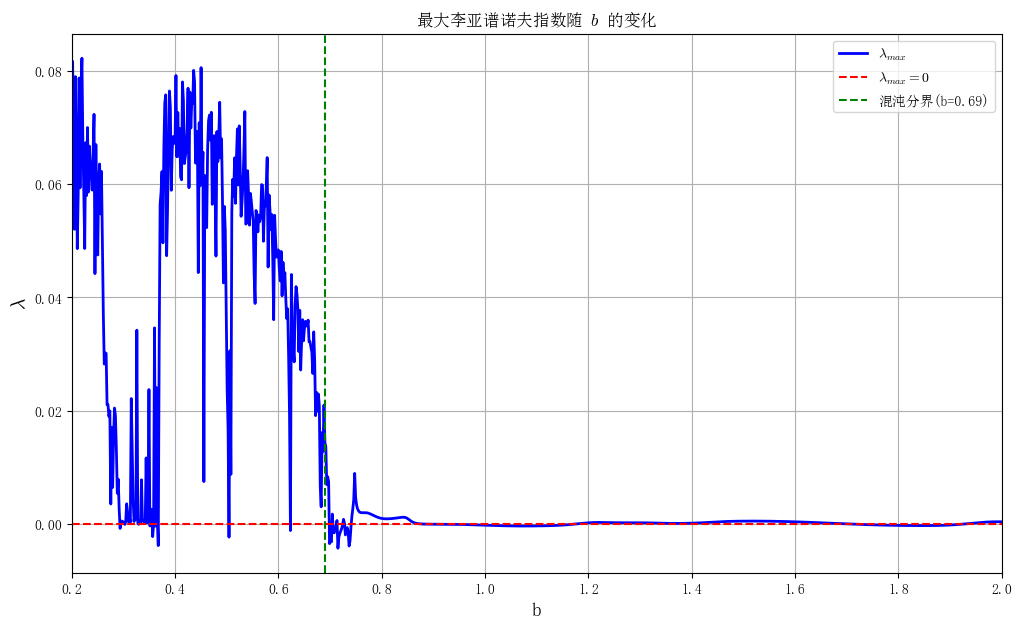

In [39]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(b_arr, res_mle, lw=2, color='b', label='$\\lambda_{max}$')
ax.axhline(0, color='red', linestyle='--', lw=1.5, label='$\\lambda_{max}=0$')
ax.axvline(0.69, color='g', linestyle='--', lw=1.5, label="混沌分界(b=0.69)")
ax.set_xlim(b_arr.min(), b_arr.max())
ax.legend()
ax.grid()
ax.set_xlabel("b")
ax.set_ylabel("$\\lambda$")
ax.set_title("最大李亚谱诺夫指数随 $b$ 的变化")
display_inline(fig)

发现对于连续系统，其在有周期轨道时其最大李雅普诺夫指数为 $0$. 而不是像一维系统一样是小于 $0$ 的，并给出一个可能的解释.

### 李亚谱诺夫指数

通过 RK4 + 定时 QR 分解，求解得在整个 $b$ 取值范围内三个李雅普诺夫指数如下：

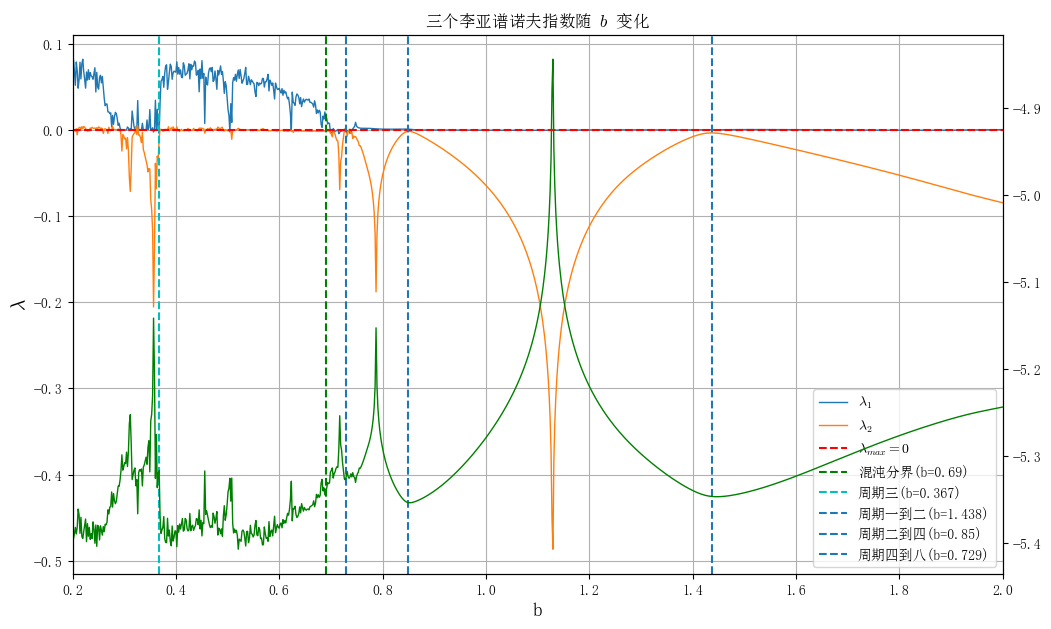

In [40]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
for i in range(2):
    ax.plot(b_arr, res_les[:,i], lw=1, label=f'$\\lambda_{i+1}$')
ax2.plot(b_arr, res_les[:,2], c='g', lw=1, label=f'$\\lambda_{2+1}$')
ax.axhline(0, color='red', linestyle='--', lw=1.5, label='$\\lambda_{max}=0$')
ax.axvline(0.69, color='g', linestyle='--', lw=1.5, label="混沌分界(b=0.69)")
ax.axvline(0.367, color='c', linestyle='--', lw=1.5, label="周期三(b=0.367)")
ax.axvline(1.438, linestyle='--', lw=1.5, label="周期一到二(b=1.438)")
ax.axvline(0.85, linestyle='--', lw=1.5, label="周期二到四(b=0.85)")
ax.axvline(0.729, linestyle='--', lw=1.5, label="周期四到八(b=0.729)")
ax.set_xlim(b_arr.min(), b_arr.max())
ax.legend()
ax.grid()
ax.set_xlabel("b")
ax.set_ylabel("$\\lambda$")
ax.set_title("三个李亚谱诺夫指数随 $b$ 变化")
display_inline(fig)

可以发现，其第二大的李雅普诺夫指数呈现和以往一维系统分叉图类似的性质，也就是其 $\lambda=0$ 时对应倍周期分叉.

同时，对于 $\lambda_2$，其也出现类似超稳定环对应的 $\lambda$ 极小值的情况. 前几个超稳定环对应位置：

- $n=2: b \approx 1.13$
- $n=4: b \approx 0.7874$
- $n=8: b \approx 0.7175$

我们同样可以用上面的数据估计费根鲍姆常数：$\delta \approx 4.90$，偏差 $5\%$

我们有理由认为，对于这个系统，其可能也有某种超稳定环.

## 参考资料

- 顾昌鑫, 计算物理学. §2.2 常微分方程初值问题的数值解法
- Steven. H. Strogatz, 非线性动力学与混沌 (Nonlinear Dynamics and Chaos), 2nd ed. §9.2, §9.3
- 部分代码编写时使用 Fitten Code AI 进行补全
- 代码实现中使用 Google Gemini AI 查询了一些函数的用法.

## 致谢

暂无

## 附一：问题

- 对于这种连续系统内，是否确实存在超稳定环？此时超稳定环出现的条件是什么？（是否有类似一维迭代系统迭代函数导数为 $0$ 的性质？）
- 可否更准确地描述并说明对于连续系统其有某一方向的李雅普诺夫指数为 $0$？（沿轨迹方向）

## 附二：学习心得

- 连续，高维系统的不动点求解及其稳定性分析
- 庞加莱截面绘制及其通过此方法将连续高维系统转换为一维迭代映射分析
- 对于连续，高维系统的最大李雅普诺夫指数和李雅普诺夫指数计算，并得到对于连续系统一定有某一方向 $\lambda=0$
- 连续，高维系统和简单一维迭代系统的相似性（分叉图，费根鲍姆常数）